In [1575]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
from matplotlib.ticker import MaxNLocator


data = np.genfromtxt('photoelectric_data.csv', delimiter=',', skip_header=1)

phi_k = 2.3 # work function of cathode in eV
phi_pt = 5.7 # work function of anode in eV

wavelengths = np.unique(data[:, 0])

data_by_wl = {}
# dict by data where 
avg_data_by_wl = {}

print(len(data))

for wl in wavelengths:
    rows = np.where(data[:, 0] == wl)

    data_by_wl[wl]  = np.copy(data[rows[0], :])
    wl_data = data_by_wl[wl]

    current_pt_list = []
    current_pt_list.append(wl_data[0])
    this_wl_avg_data = []
    for i in range(1,len(wl_data)): 
        if wl_data[i][1] == wl_data[i - 1][1] and wl_data[i][3] == wl_data[i - 1][3]:
            current_pt_list.append(wl_data[i])
        else:
            to_append = [wl,current_pt_list[0][1],np.mean([x[2] for x in current_pt_list]), np.std([x[2] for x in current_pt_list]), current_pt_list[0][3]]
            this_wl_avg_data = np.append(this_wl_avg_data,to_append) 
            current_pt_list = [wl_data[i]]
    to_append = [wl,current_pt_list[0][1],np.mean([x[2] for x in current_pt_list]), np.std([x[2] for x in current_pt_list]), current_pt_list[0][3]]
    this_wl_avg_data = np.append(this_wl_avg_data,to_append) 
    avg_data_by_wl[wl] = this_wl_avg_data.reshape(-1,5)

1103


In [1576]:
print(wavelengths)

[365.  404.7 435.8 546.1 577. ]


<ErrorbarContainer object of 3 artists>

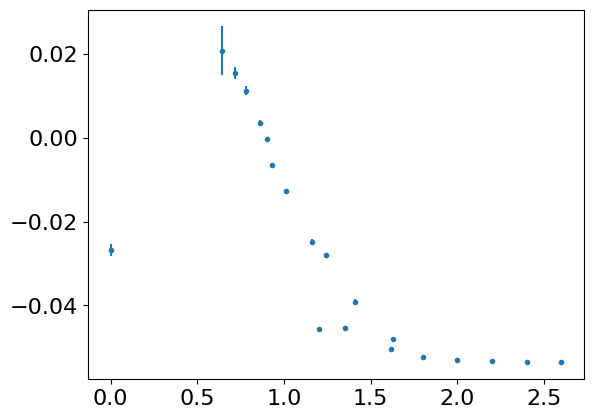

In [1577]:
cell_wl = 435.8
day = 2
# plt.errorbar([pt[1] for pt in avg_data_by_wl[cell_wl] if pt[4] == 2], [pt[2] for pt in avg_data_by_wl[cell_wl] if pt[4] == 2],[pt[3] for pt in avg_data_by_wl[cell_wl] if pt[4] == 2], fmt = '.')
plt.errorbar([pt[1] for pt in avg_data_by_wl[cell_wl] if pt[4] == day], [pt[2] for pt in avg_data_by_wl[cell_wl] if pt[4] == day],[pt[3] for pt in avg_data_by_wl[cell_wl] if pt[4] == day], fmt = '.')

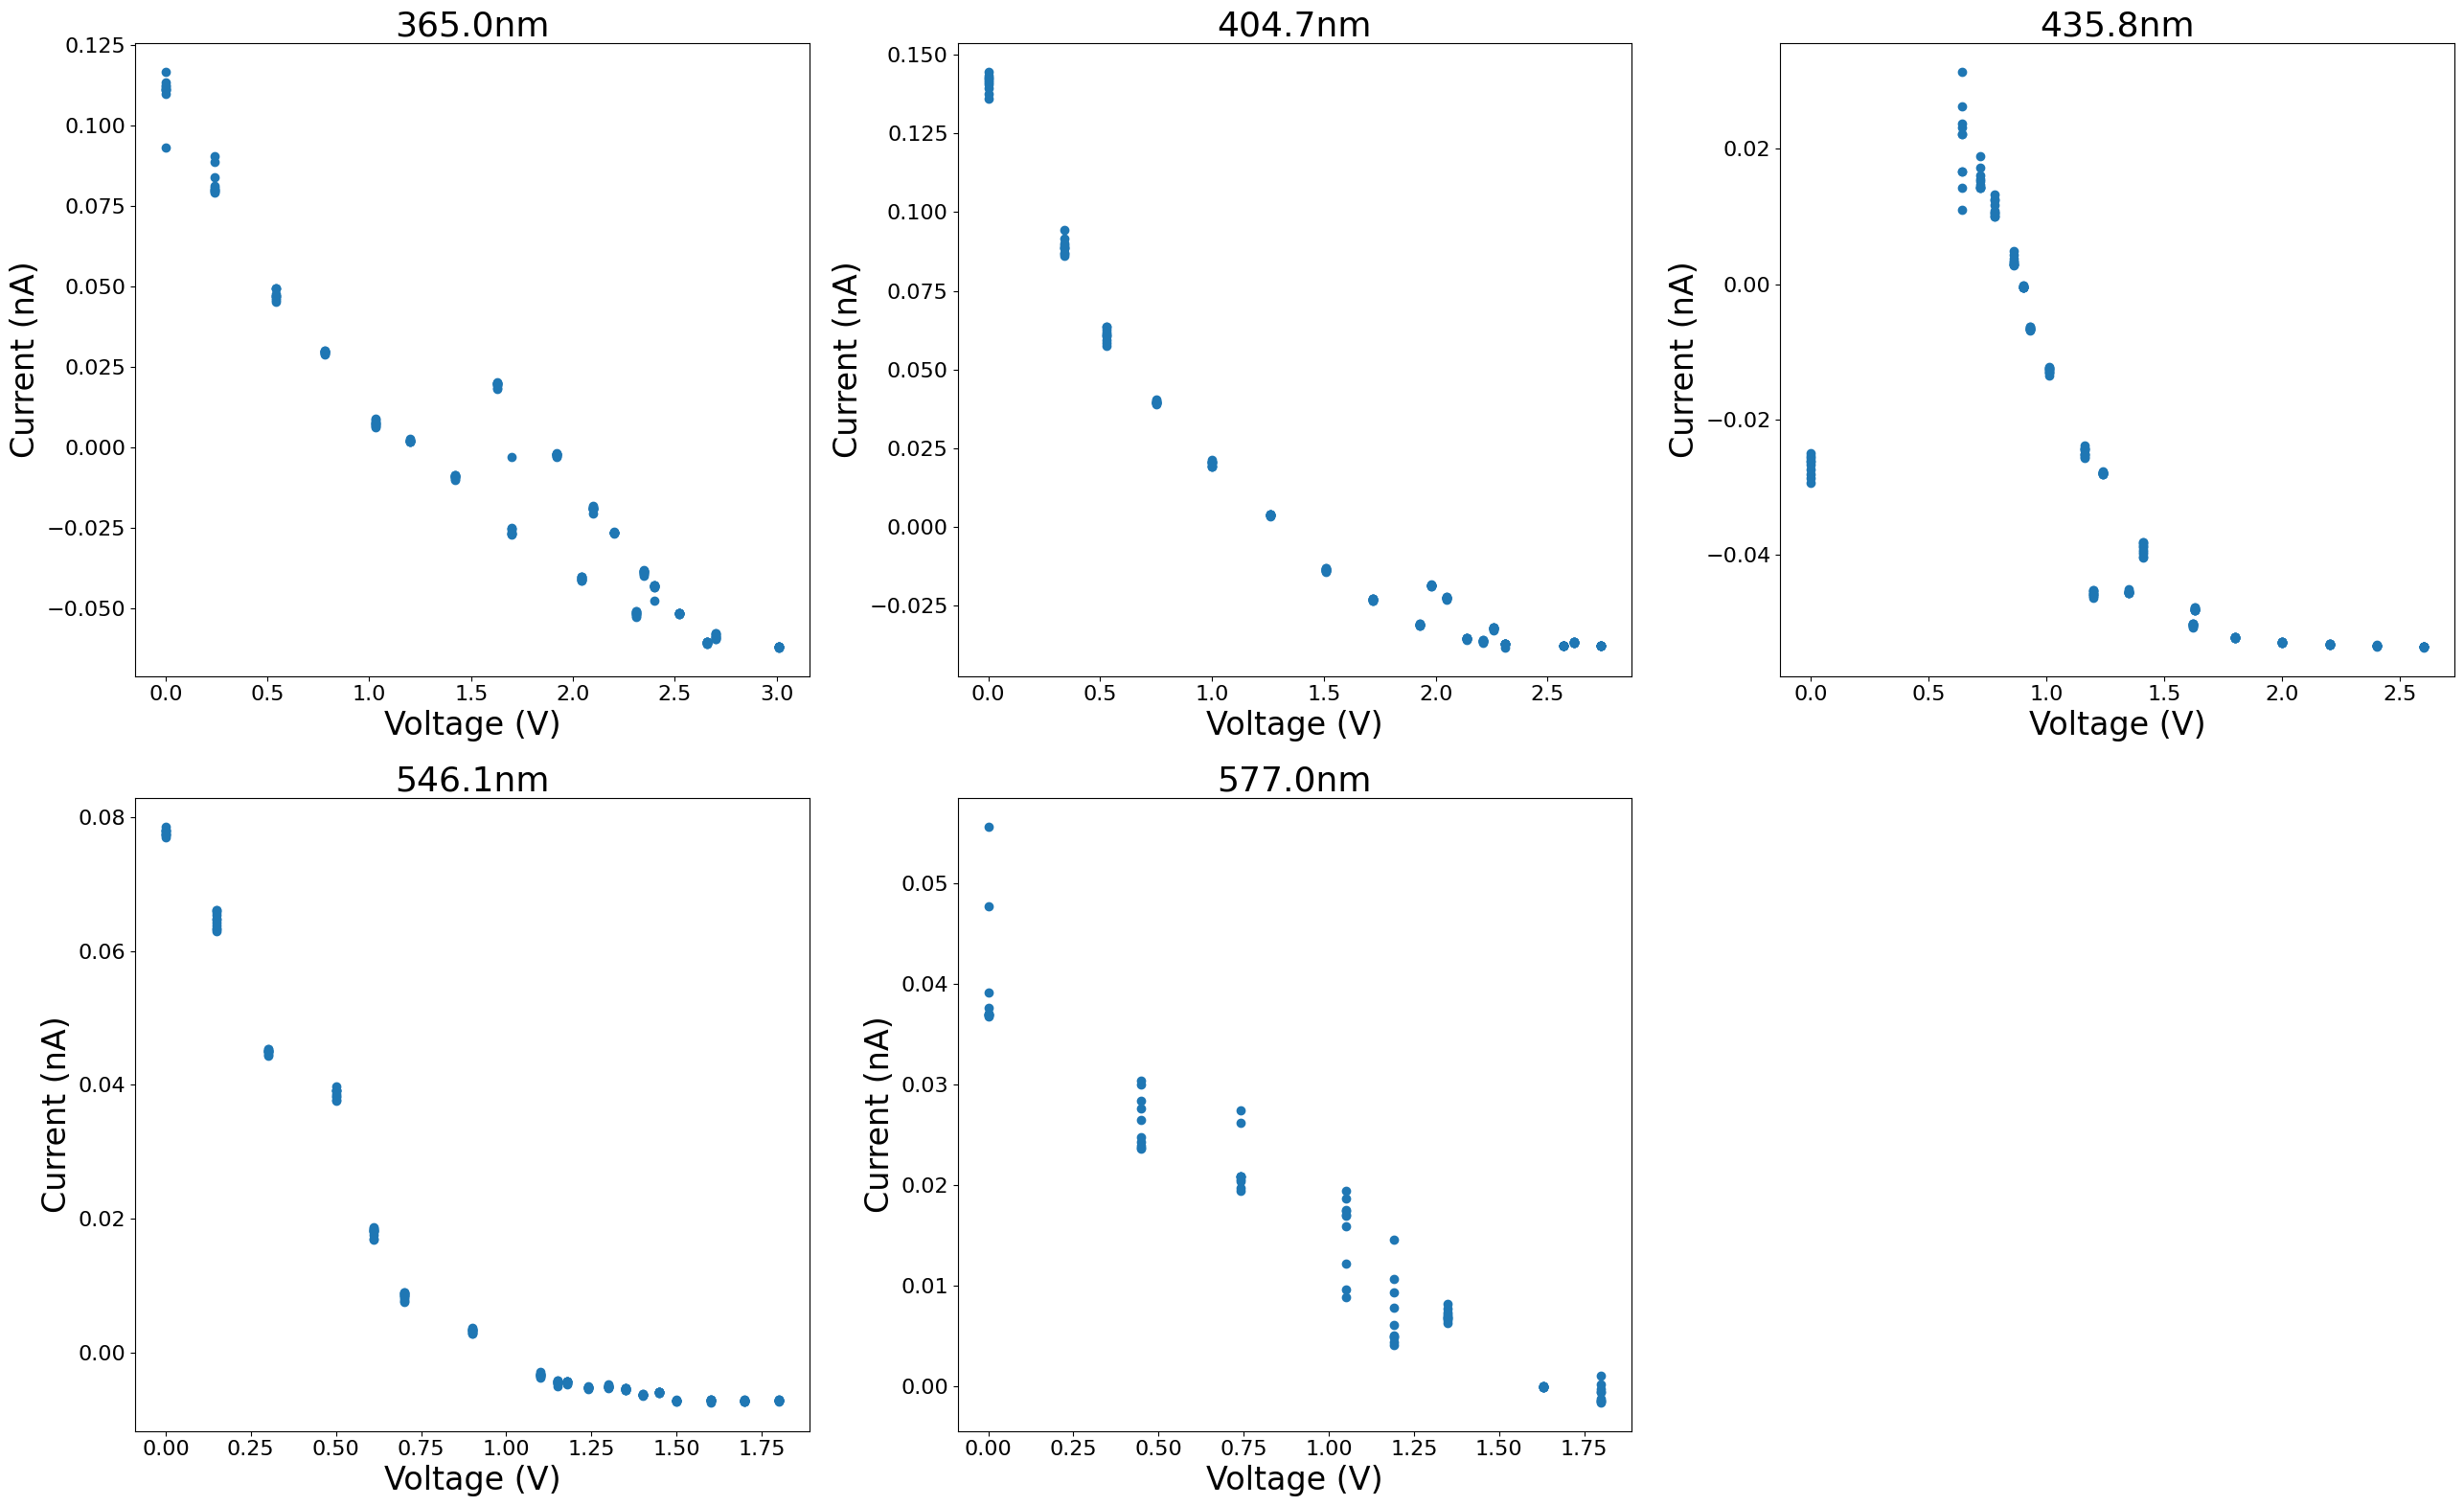

In [1578]:
fig, axes = plt.subplots(2, 3, figsize=(26, 16)) 
fontsize = 24
# plt.rc('font', size=16) # Sets the default font size to 14

for wl,pl_coord in zip(wavelengths,[[0,0],[0,1],[0,2],[1,0],[1,1]]):
    plot_wl = wl
    day_of_interest = 2
    if wl == 577:
        day_of_interest = 1
    axes[*pl_coord].scatter([pt[1] for pt in data_by_wl[plot_wl] if pt[3] == day_of_interest], [pt[2] for pt in data_by_wl[plot_wl] if pt[3] == day_of_interest])
    axes[*pl_coord].set_xlabel("Voltage (V)", fontsize = fontsize)
    axes[*pl_coord].set_ylabel("Current (nA)", fontsize = fontsize)
    axes[*pl_coord].set_title(str(wl) + "nm", fontsize = fontsize+2)

axes[1][2].set_visible(False)

# axes[1][0].set_position([0.24,0.125,0.228,0.343])
# axes[1][1].set_position([0.55,0.125,0.228,0.343])
plt.tight_layout()
plt.savefig("Raw_Data_Fig.pdf", bbox_inches='tight')

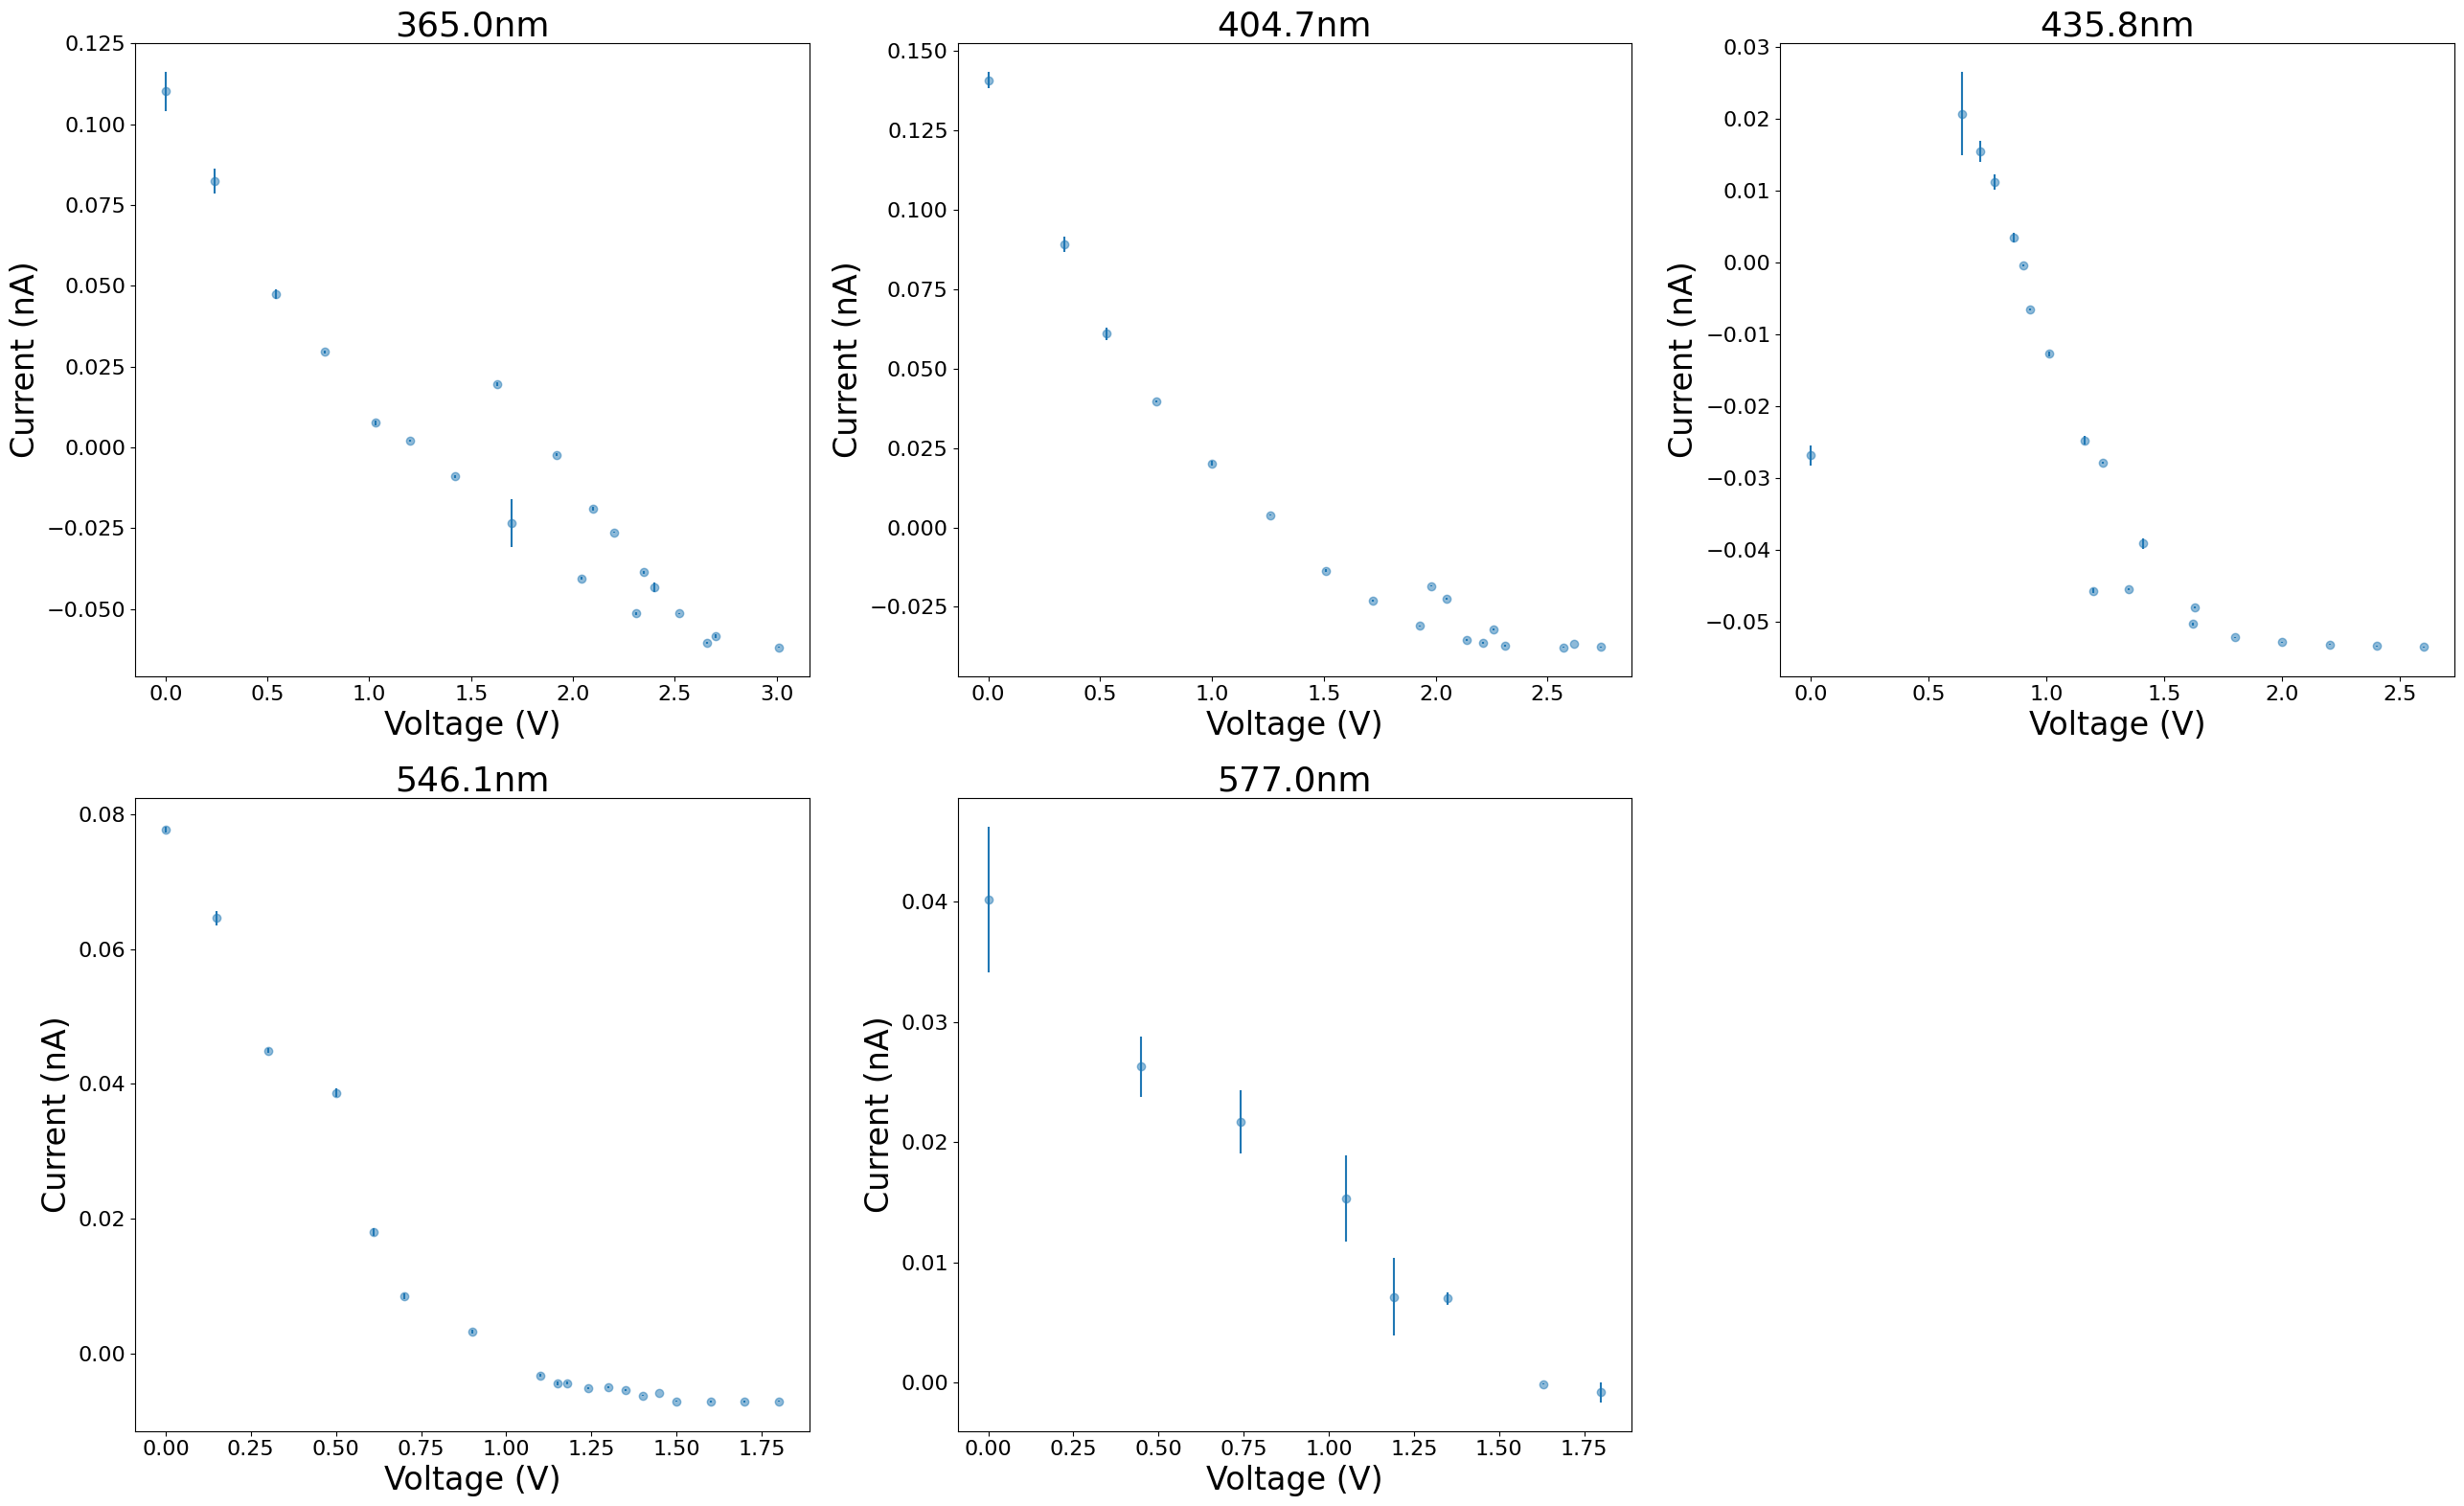

In [1579]:
fig, axes = plt.subplots(2, 3, figsize=(26, 16)) 
fontsize = 24

for wl,pl_coord in zip(wavelengths,[[0,0],[0,1],[0,2],[1,0],[1,1]]):
    plot_wl = wl
    day_of_interest = 2
    if wl == 577:
        day_of_interest = 1
    axes[*pl_coord].errorbar([pt[1] for pt in avg_data_by_wl[plot_wl] if pt[4] == day_of_interest], [pt[2] for pt in avg_data_by_wl[plot_wl] if pt[4] == day_of_interest], yerr=[pt[3] for pt in avg_data_by_wl[plot_wl] if pt[4] == day_of_interest],fmt = 'none')
    axes[*pl_coord].scatter([pt[1] for pt in avg_data_by_wl[plot_wl] if pt[4] == day_of_interest], [pt[2] for pt in avg_data_by_wl[plot_wl] if pt[4] == day_of_interest],marker = 'o',alpha = 0.5)
    axes[*pl_coord].set_xlabel("Voltage (V)", fontsize = fontsize)
    axes[*pl_coord].set_ylabel("Current (nA)", fontsize = fontsize)
    axes[*pl_coord].set_title(str(wl) + "nm", fontsize = fontsize+2)

axes[1][2].set_visible(False)

# axes[1][0].set_position([0.24,0.125,0.228,0.343])
# axes[1][1].set_position([0.55,0.125,0.228,0.343])
plt.tight_layout()
plt.savefig("Avg_Data_Fig.pdf", bbox_inches='tight')

In [1580]:
# plt.scatter(data_by_wl[plot_wl][:, 1], data_by_wl[plot_wl][:, 2])
# plt.xlabel("Voltage (V)")
# plt.ylabel("Current (nA)")

In [1581]:
def linear(x,m,b):
    return m*x + b

def calc_chi2(fit_func,fitted_x,fitted_y,fitted_std,popt):
    if len(fitted_x) != len(fitted_y):
        raise ValueError("Lengths of fitted_x and fitted_y should be equal")
    chi2_value = 0
    for i in range(len(fitted_x)):
        chi2_value += (fit_func(fitted_x[i], *popt) - fitted_y[i])**2/fitted_std[i]**2
    dof = len(fitted_x) - len(popt)
    reduced_chi2 = chi2_value/dof
    chi2_prob = chi2.cdf(chi2_value, dof)
    return chi2_value, reduced_chi2, chi2_prob

def calc_mse(fit_func,fitted_x,fitted_y,popt):
    if len(fitted_x) != len(fitted_y):
        raise ValueError("Lengths of fitted_x and fitted_y should be equal")
    mse = 0
    for i in range(len(fitted_x)):
        mse += (fit_func(fitted_x[i], *popt) - fitted_y[i])**2
    return mse/len(fitted_x)

def find_intersect(m1, b1, m2, b2):
    """
    Calculates the intersection point of two linear lines given their slopes and y-intercepts.

    Args:
        m1 (float): Slope of the first line.
        b1 (float): Y-intercept of the first line.
        m2 (float): Slope of the second line.
        b2 (float): Y-intercept of the second line.

    Returns:
        tuple: A tuple (x, y) representing the intersection point,
               or None if the lines are parallel and distinct,
               or "Coincident" if the lines are the same.
    """
    print(m1,b1,m2,b2)
    if m1 == m2:
        if b1 == b2:
            return "Coincident"  # Lines are the same
        else:
            return None  # Parallel and distinct lines, no intersection
    
    x = (b2 - b1) / (m1 - m2)
    y = m1 * x + b1  # Or y = m2 * x + b2
    return (x, y)

# Analysis for 546.1 nm

C:\Users\megan\AppData\Local\Temp\ipykernel_13632\3703191706.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear,voltages546[:cutoff],currents546[:cutoff],[-0.1,0.01], absolute_sigma=True)


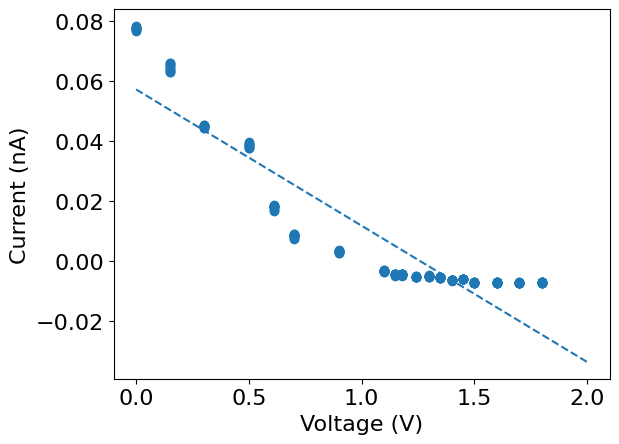

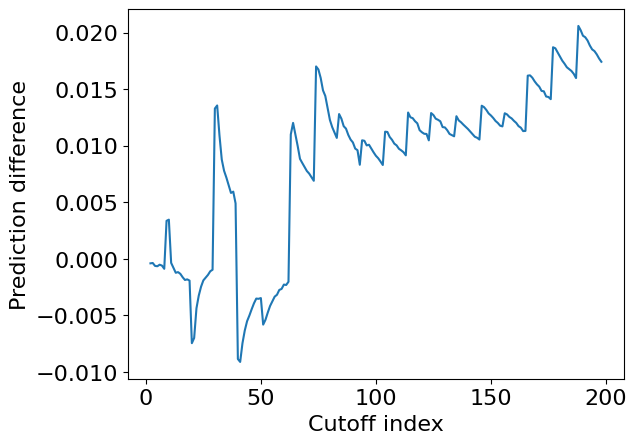

In [1582]:
vc_pairs546 = list(zip([pt[1] for pt in data_by_wl[546.1] if pt[3] == 2],[pt[2] for pt in data_by_wl[546.1] if pt[3] == 2]))
vc_pairs546.sort(key = lambda x: x[0])
voltages546 = [x[0] for x in vc_pairs546]
currents546 = [x[1] for x in vc_pairs546]
differences546 = []

for i in range(2,len(currents546)-1):
    cutoff = i
    popt, pcov = curve_fit(linear,voltages546[:cutoff],currents546[:cutoff],[-0.1,0.01], absolute_sigma=True)
    differences546.append(currents546[cutoff + 1] - linear(voltages546[cutoff + 1], *popt))
    pts_for_predicted = np.linspace(0, 2, num=30)
    predicted_line = linear(pts_for_predicted, *popt)
    
    # print("Cutting off at index", cutoff)
    # print("Optimal parameters", popt)
    # print("Difference with prediction at one past cutoff", currents546[cutoff + 1] - linear(voltages546[cutoff + 1], *popt))

plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.scatter(voltages546,currents546)
plt.plot(pts_for_predicted, predicted_line, linestyle='--')
plt.show()

plt.ylabel("Prediction difference")
plt.xlabel("Cutoff index")
plt.plot(range(2,len(currents546)-1),differences546)
plt.show()

(np.float64(1.9797951263914712e-28), np.float64(inf), np.float64(nan))
(np.float64(0.18811536741267282), np.float64(0.18811536741267282), np.float64(0.3355101685798322))
(np.float64(0.18532413880833434), np.float64(0.09266206940416717), np.float64(0.08849852750770229))
(np.float64(322.86470454727953), np.float64(107.62156818242651), np.float64(1.0))
(np.float64(305.8837928593707), np.float64(76.47094821484268), np.float64(1.0))
(np.float64(257.44853710732326), np.float64(51.48970742146465), np.float64(1.0))
(np.float64(273.30691449683883), np.float64(45.55115241613981), np.float64(1.0))
(np.float64(274.83124356837993), np.float64(39.261606224054276), np.float64(1.0))
(np.float64(300.7630984660413), np.float64(37.59538730825516), np.float64(1.0))
(np.float64(310.2380766323294), np.float64(34.470897403592154), np.float64(1.0))
(np.float64(373.763542035489), np.float64(37.3763542035489), np.float64(1.0))
(np.float64(1431.8093529166601), np.float64(130.16448662878727), np.float64(1.0))
(np

C:\Users\megan\AppData\Local\Temp\ipykernel_13632\2496726914.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear,voltages546[:cutoff],currents546[:cutoff],[-0.1,0.01])
C:\Users\megan\AppData\Local\Temp\ipykernel_13632\4181214107.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  reduced_chi2 = chi2_value/dof


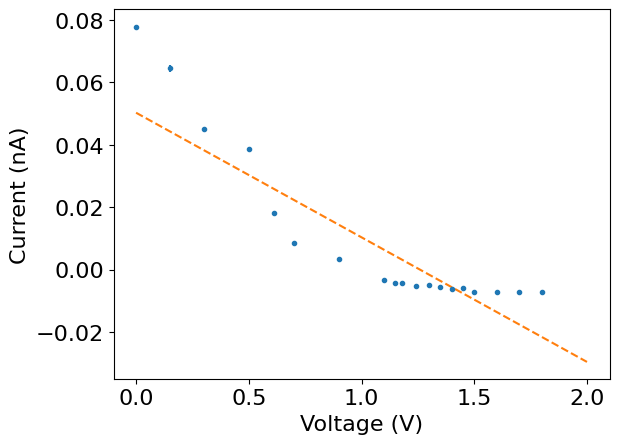

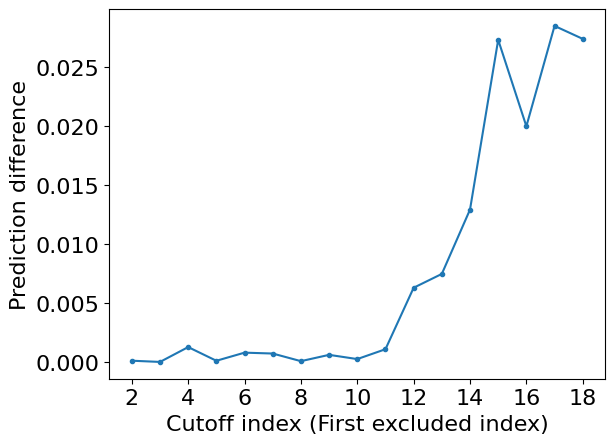

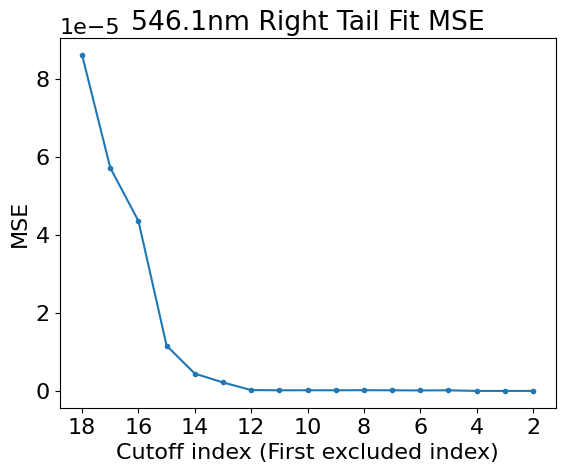

In [1638]:
# uses averaged data, fits from highest to lowest voltage (right tail)
vc_pairs546 = list(zip([pt[1] for pt in avg_data_by_wl[546.1] if pt[4] == 2],[pt[2] for pt in avg_data_by_wl[546.1] if pt[4] == 2],[pt[3] for pt in avg_data_by_wl[546.1] if pt[4] == 2]))
vc_pairs546.sort(key = lambda x: x[0], reverse=True)
voltages546 = [x[0] for x in vc_pairs546]
currents546 = [x[1] for x in vc_pairs546]
errors546 = [x[2] for x in vc_pairs546]
differences546 = []
mses546 = []
for i in range(2,len(currents546)):
    cutoff = i
    popt, pcov = curve_fit(linear,voltages546[:cutoff],currents546[:cutoff],[-0.1,0.01])
    differences546.append(currents546[cutoff] - linear(voltages546[cutoff], *popt))
    pts_for_predicted = np.linspace(0, 2, num=30)
    predicted_line = linear(pts_for_predicted, *popt)
    mses546.append(calc_mse(linear,voltages546[:cutoff],currents546[:cutoff],popt))
    # print("Cutting off at index", cutoff)
    # print("Optimal parameters", popt)
    # print("Difference with prediction at one past cutoff", currents546[cutoff + 1] - linear(voltages546[cutoff + 1], *popt))
    print(calc_chi2(linear,voltages546[:cutoff],currents546[:cutoff],errors546[:546],popt))
    # print(calc_mse(linear,voltages546[:cutoff],currents546[:cutoff],popt))

plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages546,currents546,yerr=errors546, fmt = '.')
plt.plot(pts_for_predicted, predicted_line, linestyle='--')
plt.show()
fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("Prediction difference")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents546)),differences546, marker='.')
plt.show()
fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("MSE")
plt.xlabel("Cutoff index (First excluded index)")
plt.title("546.1nm Right Tail Fit MSE")
plt.plot(range(2,len(currents546)),mses546, marker='.')
ax.invert_xaxis()
plt.savefig("546nm_right_tail_mse.pdf",bbox_inches='tight')
plt.show()

# for i in range(len(differences546) - 1):
#     print(2+i + 1, "-", i+2, "=", differences546[i + 1] - differences546[i])
#     # What it prints here is a measure of how much the difference of the first point not used to fit is increasing

cutoff pt: 2 5.158861341963676e-10
cutoff pt: 3 -1.2607724965925127e-10
cutoff pt: 4 1.5288812494936732e-07
cutoff pt: 5 -2.4743573967296074e-08
cutoff pt: 6 3.6216753222345106e-08
cutoff pt: 7 2.0674923282536657e-08
cutoff pt: 8 -2.034270461200155e-08
cutoff pt: 9 7.987888657680025e-09
cutoff pt: 10 -1.1998562788679841e-08
cutoff pt: 11 5.855736934896392e-08
cutoff pt: 12 1.955666563340477e-06
cutoff pt: 13 2.2654780906000454e-06
cutoff pt: 14 7.155797406609838e-06
cutoff pt: 15 3.199549211649909e-05
cutoff pt: 16 1.3651772877036176e-05
cutoff pt: 17 2.8944792507371867e-05
9.636363636363401e-05
-6.211881717671893e-06
0.0012521595690314715
9.133508763805551e-05
0.0007800006626697275
0.0007051063701263978
5.853343642571477e-05
0.0005932645555198653
0.00023551431025488736
0.001070722753045446
0.00628490375124364
0.007456394155670479
0.01290772019059716
0.02730399130859188
0.01993691753082047
0.02843714825597423
0.02731011608773817


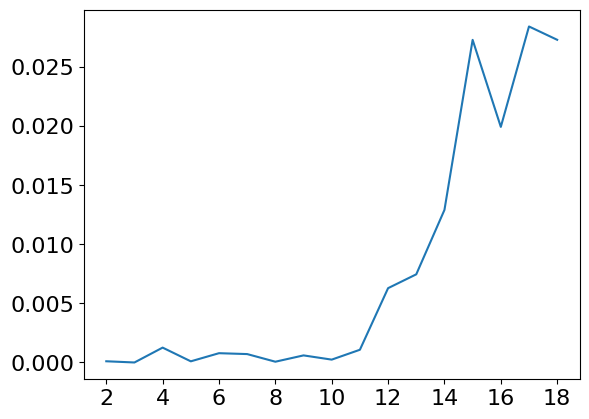

In [1670]:
mse_differences546 = []
for i in range(0,len(mses546)-1):
    mse_differences546.append(mses546[i+1] - mses546[i])
    print("cutoff pt:", 2+ i, mses546[i+1] - mses546[i])

for i in range(len(mses546)):
    print(differences546[i] - mses546[i])

fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(range(2,len(mses546)+2), [differences546[i] - mses546[i] for i in range(len(mses546))])

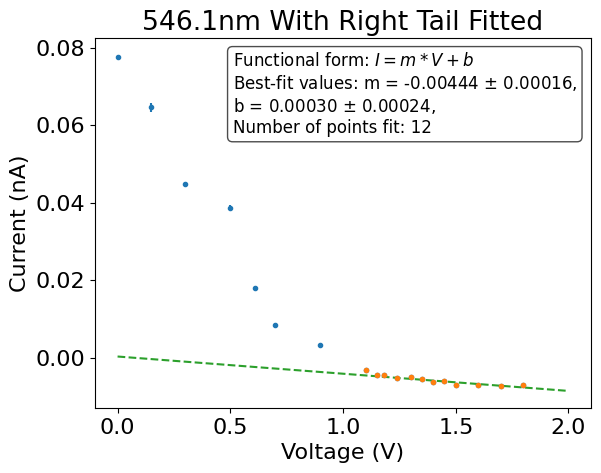

0.006953311419526672
0.9 1.1
[-0.004  0.   ]
2.1752965903179294e-06 4.440774680917975e-06 1.1596572087527813e-05


In [1585]:
# for 546, using cutoff 12 on the right tail (ie use the rightmost point and cutoff 12 wrt to that)
cutoff_r = 12
popt_r, pcov_r = curve_fit(linear,voltages546[:cutoff_r],currents546[:cutoff_r],[-5,7], sigma=errors546[:cutoff_r],absolute_sigma=True)
predicted_line_r = linear(pts_for_predicted, *popt_r)
    
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages546,currents546,yerr=errors546, fmt = '.')
plt.errorbar(voltages546[:cutoff_r],currents546[:cutoff_r], fmt = '.')
plt.plot(pts_for_predicted, predicted_line_r, linestyle='--')
plt.title("546.1nm With Right Tail Fitted")

text_display_string_info = f"""Functional form: $I = m*V + b$
Best-fit values: m = {popt_r[0]:.5f} $\\pm$ {pcov_r[0][0]**0.5:.5f},
b = {popt_r[1]:.5f} $\\pm$ {pcov_r[1][1]**0.5:.5f},
Number of points fit: {cutoff_r}"""
plt.text(
    0.51, 0.079,text_display_string_info,    
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))
plt.savefig("546nm_right_tail_fit.pdf",bbox_inches='tight')
plt.show()

print(currents546[cutoff_r] - linear(voltages546[cutoff_r], *popt_r))
print(voltages546[cutoff_r], voltages546[cutoff_r-1])
print(popt_r)
print(mses546[cutoff_r-1],mses546[cutoff_r], mses546[cutoff_r+1])

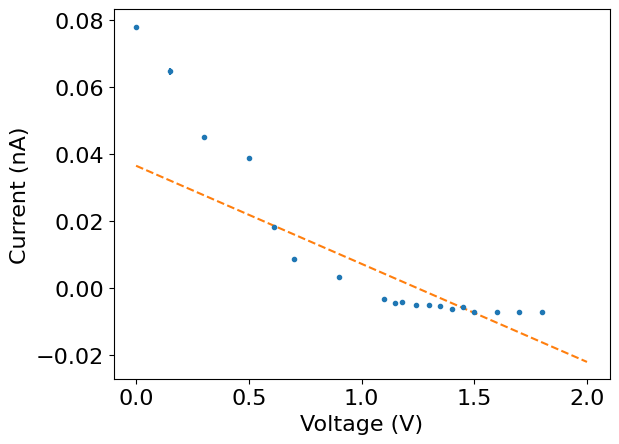

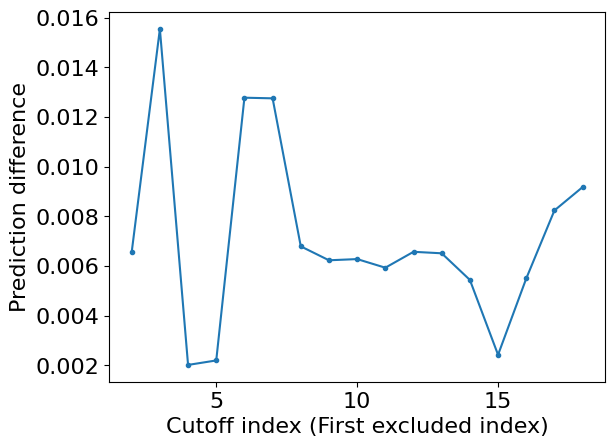

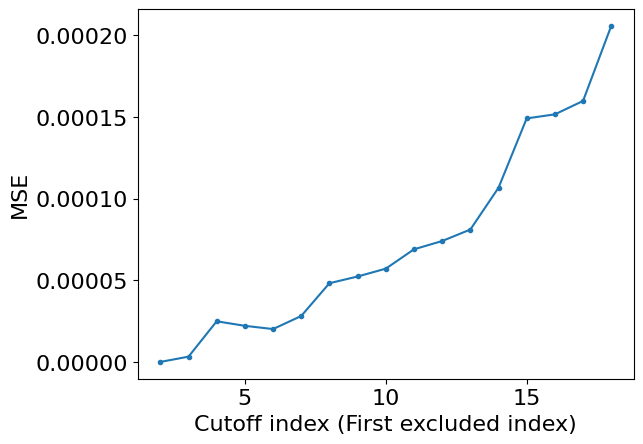

In [1586]:
# uses averaged data
# fits from left side points to right 
vc_pairs546 = list(zip([pt[1] for pt in avg_data_by_wl[546.1] if pt[4] == 2],[pt[2] for pt in avg_data_by_wl[546.1] if pt[4] == 2],[pt[3] for pt in avg_data_by_wl[546.1] if pt[4] == 2]))
vc_pairs546.sort(key = lambda x: x[0])
voltages546 = [x[0] for x in vc_pairs546]
currents546 = [x[1] for x in vc_pairs546]
errors546 = [x[2] for x in vc_pairs546]
differences546 = []
mses546 = []

for i in range(2,len(currents546)):
    cutoff = i
    popt, pcov = curve_fit(linear,voltages546[:cutoff],currents546[:cutoff],[-0.1,0.01], errors546[:cutoff],absolute_sigma=True)
    differences546.append(abs(currents546[cutoff] - linear(voltages546[cutoff], *popt)))
    pts_for_predicted = np.linspace(0, 2, num=30)
    predicted_line = linear(pts_for_predicted, *popt)
    mses546.append(calc_mse(linear,voltages546[:cutoff],currents546[:cutoff],popt))

    # print("Cutting off at index", cutoff)
    # print("Optimal parameters", popt)
    # print("Difference with prediction at one past cutoff", currents546[cutoff + 1] - linear(voltages546[cutoff + 1], *popt))
    # print(calc_chi2(linear,voltages546[:cutoff],currents546[:cutoff],errors546[:546],popt))

plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages546,currents546,yerr=errors546, fmt = '.')
plt.plot(pts_for_predicted, predicted_line, linestyle='--')
plt.show()

plt.ylabel("Prediction difference")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents546)),differences546, marker='.')
plt.show()

plt.ylabel("MSE")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents546)),mses546, marker='.')
plt.show()

# for i in range(len(differences546) - 1):
#     print(2+i + 1, "-", i+2, "=", differences546[i + 1] - differences546[i])
    # What it prints here is a measure of how much the difference of the first point not used to fit is increasing

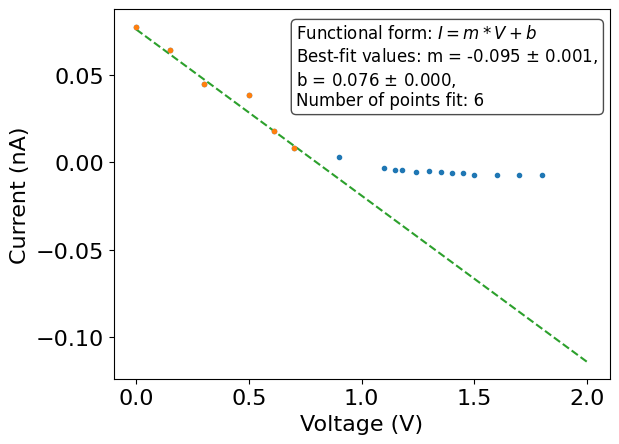

0.012772373254546556
0.9
[-0.095  0.076]
[0.001 0.   ]


In [1587]:
# for 546, using cutoff 6 on the left tail (ie use the leftmost, 0 voltage, point and cutoff 6 wrt to that)
cutoff_l = 6
popt_l, pcov_l = curve_fit(linear,voltages546[:cutoff_l],currents546[:cutoff_l],[-0.1,0.01], errors546[:cutoff_l],absolute_sigma=True)
predicted_line_l = linear(pts_for_predicted, *popt_l)
    

plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages546,currents546,yerr=errors546, fmt = '.')
plt.errorbar(voltages546[:cutoff_l],currents546[:cutoff_l], fmt = '.')
plt.plot(pts_for_predicted, predicted_line_l, linestyle='--')
text_display_string_info = f"""Functional form: $I = m*V + b$
Best-fit values: m = {popt_l[0]:.3f} $\\pm$ {pcov_l[0][0]**0.5:.3f},
b = {popt_l[1]:.3f} $\\pm$ {pcov_l[1][1]**0.5:.3f},
Number of points fit: {cutoff_l}"""
plt.text(
    0.71, 0.079,text_display_string_info,    
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))
plt.savefig("546nm_left_tail_fit.pdf",bbox_inches='tight')

plt.show()



print(currents546[cutoff_l] - linear(voltages546[cutoff_l], *popt_l))
print(voltages546[cutoff_l])
print(popt_l)
print(np.sqrt(np.diag(pcov_l)))

-0.09516675990251384 0.0761377106577159 -0.004439702122223786 0.00030242049047473485


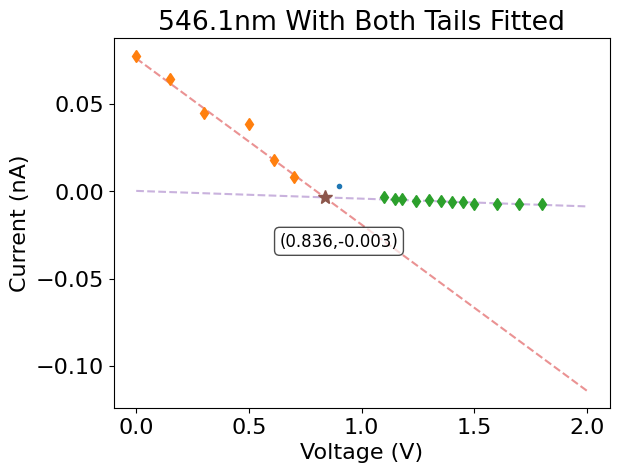

In [1588]:
plt.errorbar(voltages546,currents546,yerr=errors546, fmt = '.')
plt.errorbar(voltages546[:cutoff_l],currents546[:cutoff_l], fmt = 'd')
plt.errorbar(voltages546[len(voltages546) - cutoff_r:],currents546[len(voltages546) - cutoff_r:], fmt = 'd')

plt.plot(pts_for_predicted, predicted_line_l, linestyle='--',alpha =0.5)
plt.plot(pts_for_predicted, predicted_line_r, linestyle='--', alpha = 0.5)
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")

inter_x,inter_y = find_intersect(*popt_l,*popt_r)
plt.plot(inter_x,inter_y,marker = '*',ms = 10)
intersection_text = f"({inter_x:.3f},{inter_y:.3f})"
plt.text(
    inter_x - 0.2 , inter_y-0.02,intersection_text,    
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))
plt.title("546.1nm With Both Tails Fitted")
plt.savefig("546nm_both_tail_fit.pdf",bbox_inches='tight')

plt.show()

In [1589]:
zero_voltage_current_546 = 0.07769799999999999

# Analysis for 404.7 nm

In [1590]:
# vc_pairs404 = list(zip([pt[1] for pt in data_by_wl[404.7] if pt[3] == 2],[pt[2] for pt in data_by_wl[404.7] if pt[3] == 2]))
# vc_pairs404.sort(key = lambda x: x[0])
# voltages404 = [x[0] for x in vc_pairs404]
# currents404 = [x[1] for x in vc_pairs404]
# pts_for_predicted = np.linspace(0, 3, num=30)
# differences404 = []

# for i in range(2,len(currents404)):
#     cutoff = i
#     popt, pcov = curve_fit(linear,voltages404[:cutoff],currents404[:cutoff],[0,0.01], absolute_sigma=True)
#     differences404.append(currents404[cutoff + 1] - linear(voltages404[cutoff + 1], *popt))
#     predicted_line = linear(pts_for_predicted, *popt)

#     # print("Cutting off at index", cutoff)
#     # print("Optimal parameters", popt)
#     # print("Difference with prediction at one past cutoff", abs(currents404[cutoff + 1] - linear(voltages404[cutoff + 1], *popt)))


# plt.xlabel("Voltage (V)")
# plt.ylabel("Current (nA)")
# plt.scatter(voltages404,currents404)
# plt.plot(pts_for_predicted, predicted_line, linestyle='--')
# plt.show()

# plt.ylabel("Prediction difference")
# plt.xlabel("Cutoff index (First excluded index)")
# plt.plot(range(2,len(currents404)),differences404)
# plt.show()

(np.float64(0.0), np.float64(nan), np.float64(nan))
(np.float64(198.80671027748338), np.float64(198.80671027748338), np.float64(1.0))
(np.float64(193.60447348524303), np.float64(96.80223674262152), np.float64(1.0))
(np.float64(518.4934423972971), np.float64(172.83114746576572), np.float64(1.0))
(np.float64(501.11791201475467), np.float64(125.27947800368867), np.float64(1.0))
(np.float64(505.6821896859047), np.float64(101.13643793718094), np.float64(1.0))
(np.float64(2602.787783703042), np.float64(433.797963950507), np.float64(1.0))
(np.float64(6392.846840324096), np.float64(913.2638343320137), np.float64(1.0))
(np.float64(6568.717636452745), np.float64(821.0897045565931), np.float64(1.0))
(np.float64(6574.624943292136), np.float64(730.5138825880151), np.float64(1.0))
(np.float64(8235.164272136488), np.float64(823.5164272136487), np.float64(1.0))
(np.float64(20241.367485523213), np.float64(1840.1243168657466), np.float64(1.0))
(np.float64(36031.64721107223), np.float64(3002.637267589352

C:\Users\megan\AppData\Local\Temp\ipykernel_13632\4181214107.py:11: RuntimeWarning: invalid value encountered in scalar divide
  reduced_chi2 = chi2_value/dof


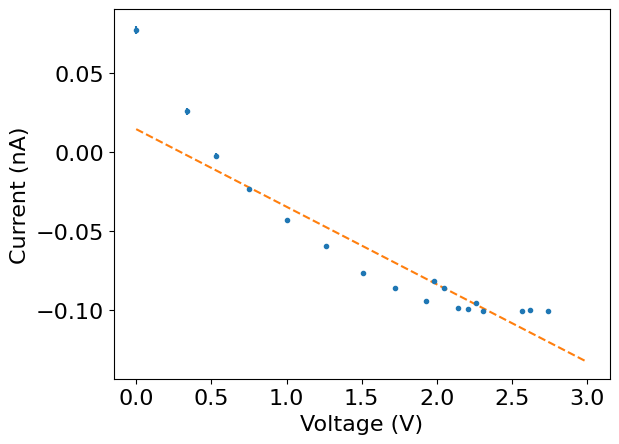

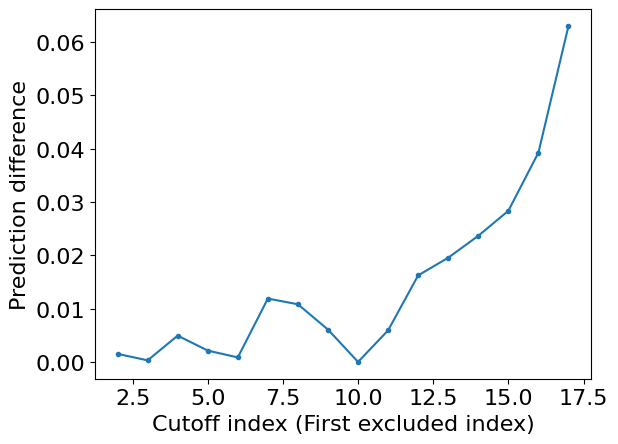

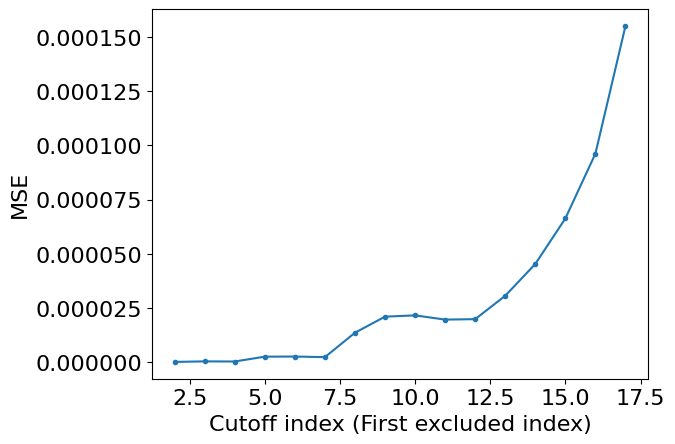

In [1644]:
# 404.7 nm fitting to right tail
vc_pairs404 = list(zip([pt[1] for pt in avg_data_by_wl[404.7] if pt[4] == 2],[pt[2] for pt in avg_data_by_wl[404.7] if pt[4] == 2],[pt[3] for pt in avg_data_by_wl[404.7] if pt[4] == 2]))
vc_pairs404.sort(key = lambda x: x[0], reverse=True)
voltages404 = [x[0] for x in vc_pairs404]
currents404 = [x[1] for x in vc_pairs404]
errors404 = [x[2] for x in vc_pairs404]
mses404 = []

norm_shift = zero_voltage_current_546 - max(currents404)
for i in range(len(currents404)):
    currents404[i] = currents404[i] +  norm_shift
pts_for_predicted = np.linspace(0, 3, num=30)
differences404 = []

for i in range(2,len(currents404)):
    cutoff = i
    popt, pcov = curve_fit(linear,voltages404[:cutoff],currents404[:cutoff],[0,0.01], absolute_sigma=True)
    differences404.append(abs(currents404[cutoff] - linear(voltages404[cutoff], *popt)))
    predicted_line = linear(pts_for_predicted, *popt)
    mses404.append(calc_mse(linear,voltages404[:cutoff],currents404[:cutoff],popt))

    # print("Cutting off at index", cutoff)
    # print("Optimal parameters", popt)
    # print("Difference with prediction at one past cutoff", abs(currents404[cutoff + 1] - linear(voltages404[cutoff + 1], *popt)))
    print(calc_chi2(linear,voltages404[:cutoff],currents404[:cutoff],errors404[:cutoff],popt))


plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages404,currents404,fmt = '.', yerr=errors404)
plt.plot(pts_for_predicted, predicted_line, linestyle='--')
plt.show()

plt.ylabel("Prediction difference")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents404)),differences404, marker = '.')
plt.show()

plt.ylabel("MSE")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents404)),mses404, marker='.')
plt.show()

# for i in range(len(differences404) - 1):
#     print(i + 1 + 2, "-", i + 2, "=", differences404[i + 1] - differences404[i])

cutoff pt: 2 2.511680705994883e-07
cutoff pt: 3 -5.960836598478858e-08
cutoff pt: 4 2.239672715338426e-06
cutoff pt: 5 5.590445818450796e-08
cutoff pt: 6 -2.8518050054510025e-07
cutoff pt: 7 1.127023607055095e-05
cutoff pt: 8 7.42872887750559e-06
cutoff pt: 9 6.028996040110237e-07
cutoff pt: 10 -1.9548083211300944e-06
cutoff pt: 11 2.0431223737486134e-07
cutoff pt: 12 1.0805743569321091e-05
cutoff pt: 13 1.4690497777771412e-05
cutoff pt: 14 2.101573164969908e-05
cutoff pt: 15 2.994382065382656e-05
cutoff pt: 16 5.898420875683658e-05
4 2.239672715338426e-06 9.577985230734986e-08
7 1.127023607055095e-05 4.4039127551850667e-07
8 7.42872887750559e-06 2.245365408023914e-06
12 1.0805743569321091e-05 1.975332484590486e-06
13 1.4690497777771412e-05 2.778097128656905e-06
14 2.101573164969908e-05 3.7707971827497806e-06
15 2.994382065382656e-05 5.097330603284342e-06
16 5.898420875683658e-05 6.8720798926087864e-06


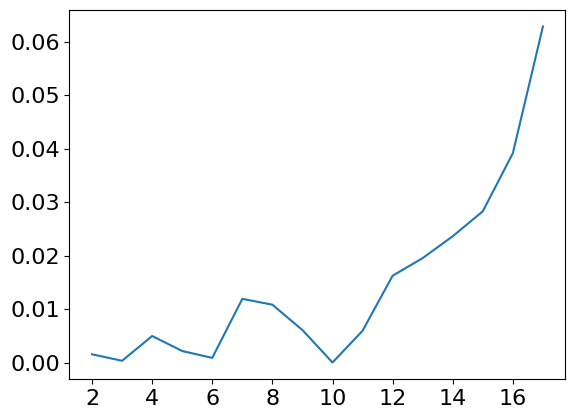

In [1674]:
mse_differences404 = []
for i in range(0,len(mses404)-1):
    mse_differences404.append(mses404[i+1] - mses404[i])
    print("cutoff pt:", i + 2, mses404[i+1] - mses404[i])
for i in range(1,len(mse_differences404)):
    if mse_differences404[i] > sum(mse_differences404[:i])/i:
        print(i+2,mse_differences404[i],sum(mse_differences404[:i])/i)
# print(mse_differences404)
fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(range(2,len(mses404)+2), [differences404[i] - mses404[i] for i in range(len(mses404))])

cutoff pt: 2 5.158861341963676e-10
cutoff pt: 3 -1.2607724965925127e-10
cutoff pt: 4 1.5288812494936732e-07
cutoff pt: 5 -2.4743573967296074e-08
cutoff pt: 6 3.6216753222345106e-08
cutoff pt: 7 2.0674923282536657e-08
cutoff pt: 8 -2.034270461200155e-08
cutoff pt: 9 7.987888657680025e-09
cutoff pt: 10 -1.1998562788679841e-08
cutoff pt: 11 5.855736934896392e-08
cutoff pt: 12 1.955666563340477e-06
cutoff pt: 13 2.2654780906000454e-06
cutoff pt: 14 7.155797406609838e-06
cutoff pt: 15 3.199549211649909e-05
cutoff pt: 16 1.3651772877036176e-05
cutoff pt: 17 2.8944792507371867e-05
4 1.5288812494936732e-07 1.9490444226855816e-10
6 3.6216753222345106e-08 3.213358996665209e-08
11 5.855736934896392e-08 1.7896961958720973e-08
12 1.955666563340477e-06 2.1963002697745267e-08
13 2.2654780906000454e-06 1.9775423548344812e-07
14 7.155797406609838e-06 3.7006455674316456e-07
15 3.199549211649909e-05 8.920440067329087e-07
16 1.3651772877036176e-05 3.1137188717162073e-06
17 2.8944792507371867e-05 3.8162558

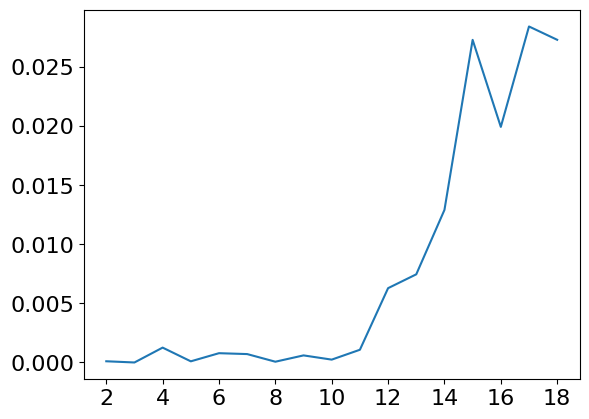

In [1675]:
mse_differences546 = []
for i in range(0,len(mses546)-1):
    mse_differences546.append(mses546[i+1] - mses546[i])
    print("cutoff pt:", i + 2, mses546[i+1] - mses546[i])
for i in range(1,len(mse_differences546)):
    if mse_differences546[i] > sum(mse_differences546[:i])/i:
        print(i+2,mse_differences546[i],sum(mse_differences546[:i])/i)
# print(mse_differences546)
fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(range(2,len(mses546)+2), [differences546[i] - mses546[i] for i in range(len(mses546))])

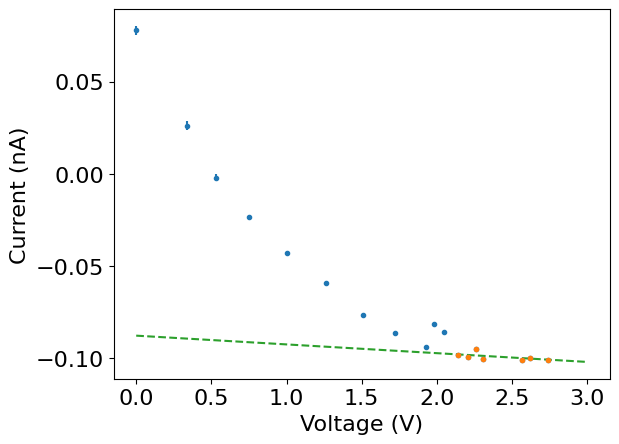

0.011913291653649363
2.05 2.14
[-0.005 -0.088]
1.3472192448143483e-05 2.0900921325649073e-05 2.1503820929660097e-05


In [1593]:
# 404.7 nm, using cutoff 7 for right tail based on rise in MSE past that
cutoff_r = 7
popt_r, pcov_r = curve_fit(linear,voltages404[:cutoff_r],currents404[:cutoff_r],[-0.1,0.01])
predicted_line_r = linear(pts_for_predicted, *popt_r)
    
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages404,currents404,yerr=errors404, fmt = '.')
plt.errorbar(voltages404[:cutoff_r],currents404[:cutoff_r], fmt = '.')

plt.plot(pts_for_predicted, predicted_line_r, linestyle='--')
plt.show()

print(currents404[cutoff_r] - linear(voltages404[cutoff_r], *popt_r))
print(voltages404[cutoff_r], voltages404[cutoff_r-1])
print(popt_r)
print(mses404[cutoff_r-1],mses404[cutoff_r],mses404[cutoff_r+1])

C:\Users\megan\AppData\Local\Temp\ipykernel_13632\3089470793.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear,voltages404[:cutoff],currents404[:cutoff],[0,0.01])


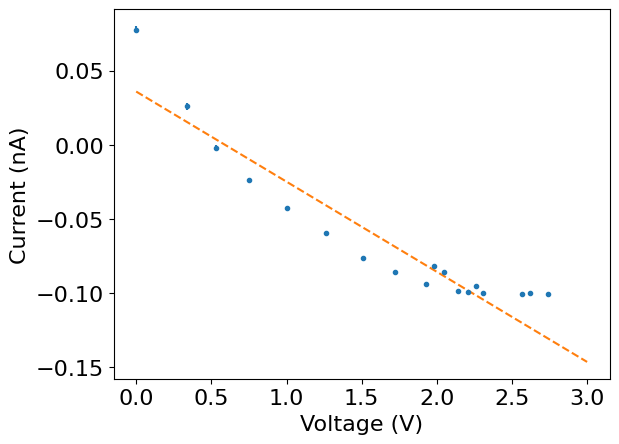

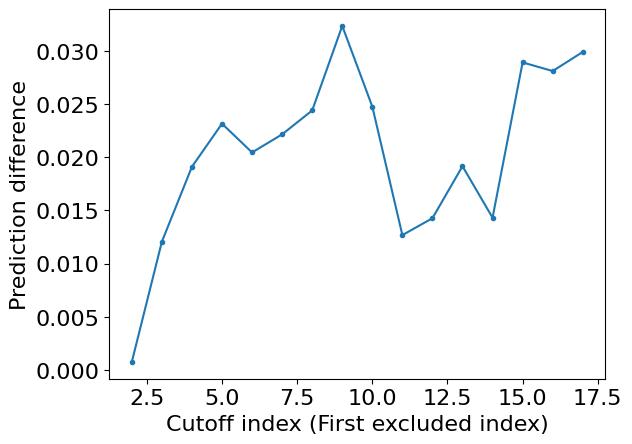

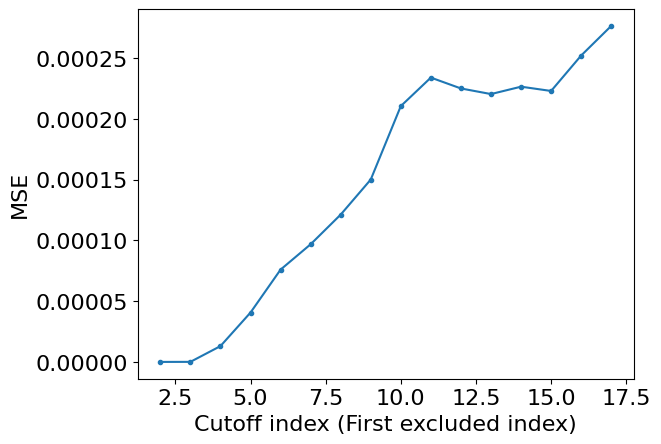

In [1594]:
# 404.7 nm fitting to left tail
vc_pairs404 = list(zip([pt[1] for pt in avg_data_by_wl[404.7] if pt[4] == 2],[pt[2] for pt in avg_data_by_wl[404.7] if pt[4] == 2],[pt[3] for pt in avg_data_by_wl[404.7] if pt[4] == 2]))
vc_pairs404.sort(key = lambda x: x[0])
voltages404 = [x[0] for x in vc_pairs404]
currents404 = [x[1] for x in vc_pairs404]
errors404 = [x[2] for x in vc_pairs404]
mses404 = []
differences404 = []

norm_shift = zero_voltage_current_546 - max(currents404)
for i in range(len(currents404)):
    currents404[i] = currents404[i] +  norm_shift
pts_for_predicted = np.linspace(0, 3, num=30)

for i in range(2,len(currents404)):
    cutoff = i
    popt, pcov = curve_fit(linear,voltages404[:cutoff],currents404[:cutoff],[0,0.01])
    differences404.append(abs(currents404[cutoff] - linear(voltages404[cutoff], *popt)))
    predicted_line = linear(pts_for_predicted, *popt)
    mses404.append(calc_mse(linear,voltages404[:cutoff],currents404[:cutoff],popt))
    # print("Cutting off at index", cutoff)
    # print("Optimal parameters", popt)
    # print("Difference with prediction at one past cutoff", abs(currents404[cutoff + 1] - linear(voltages404[cutoff + 1], *popt)))
    # print(calc_chi2(linear,voltages404[:cutoff],currents404[:cutoff],errors404[:cutoff],popt))


plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages404,currents404,fmt = '.', yerr=errors404)
plt.plot(pts_for_predicted, predicted_line, linestyle='--')
plt.show()

plt.ylabel("Prediction difference")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents404)),differences404, marker = '.')
plt.show()

plt.ylabel("MSE")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents404)),mses404, marker='.')
plt.show()

# for i in range(len(differences404) - 1):
#     print(i + 1 + 2, "-", i + 2, "=", differences404[i + 1] - differences404[i])

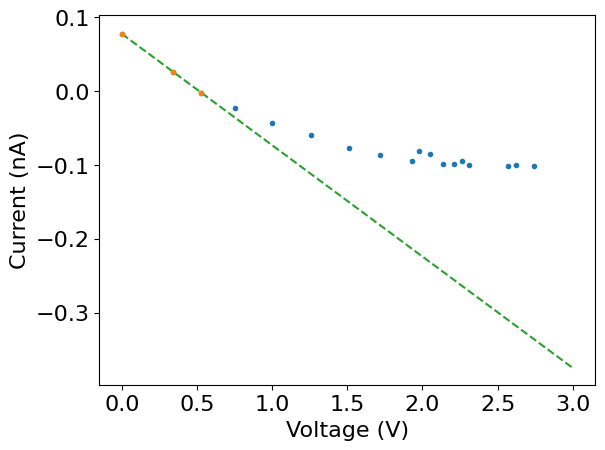

0.012055294036061093
0.75
[-0.151  0.078]


In [1595]:
# for 404, using cutoff 3 for left tail
cutoff_l = 3
popt_l, pcov_l = curve_fit(linear,voltages404[:cutoff_l],currents404[:cutoff_l],[-0.1,0.01])
predicted_line_l = linear(pts_for_predicted, *popt_l)
    
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages404,currents404,yerr=errors404, fmt = '.')
plt.errorbar(voltages404[:cutoff_l],currents404[:cutoff_l], fmt = '.')

plt.plot(pts_for_predicted, predicted_line_l, linestyle='--')
plt.show()

print(currents404[cutoff_l] - linear(voltages404[cutoff_l], *popt_l))
print(voltages404[cutoff_l])
print(popt_l,)

-0.15086803051317624 0.07758772884882106 -0.004751050036452586 -0.08788363907892158


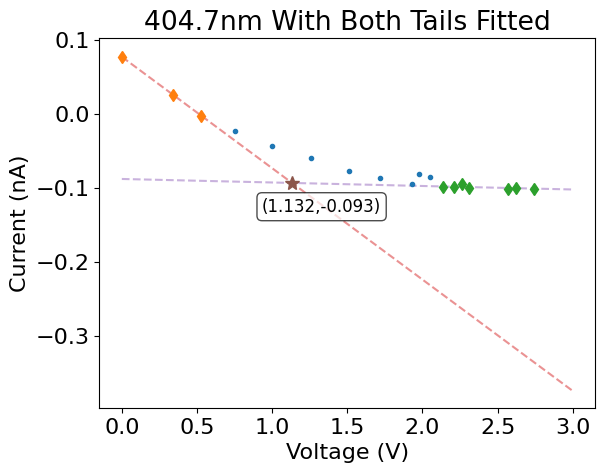

In [1596]:
plt.errorbar(voltages404,currents404,yerr=errors404, fmt = '.')
plt.errorbar(voltages404[:cutoff_l],currents404[:cutoff_l], fmt = 'd')
plt.errorbar(voltages404[len(voltages404) - cutoff_r:],currents404[len(voltages404) - cutoff_r:], fmt = 'd')

plt.plot(pts_for_predicted, predicted_line_l, linestyle='--',alpha =0.5)
plt.plot(pts_for_predicted, predicted_line_r, linestyle='--', alpha = 0.5)

plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
inter_x,inter_y = find_intersect(*popt_l,*popt_r)
plt.plot(inter_x,inter_y,marker = '*',ms = 10)
intersection_text = f"({inter_x:.3f},{inter_y:.3f})"
plt.text(
    inter_x - 0.2 , inter_y-0.02,intersection_text,    
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))
plt.title("404.7nm With Both Tails Fitted")
plt.savefig("404nm_both_tail_fit.pdf",bbox_inches='tight')

# Analysis for 435.8 nm

[np.float64(2.6), np.float64(2.4), np.float64(2.2), np.float64(2.0), np.float64(1.8), np.float64(1.63), np.float64(1.62), np.float64(1.41), np.float64(1.35), np.float64(1.24), np.float64(1.2), np.float64(1.16), np.float64(1.01), np.float64(0.93), np.float64(0.9), np.float64(0.86), np.float64(0.78), np.float64(0.72), np.float64(0.64), np.float64(0.0)]


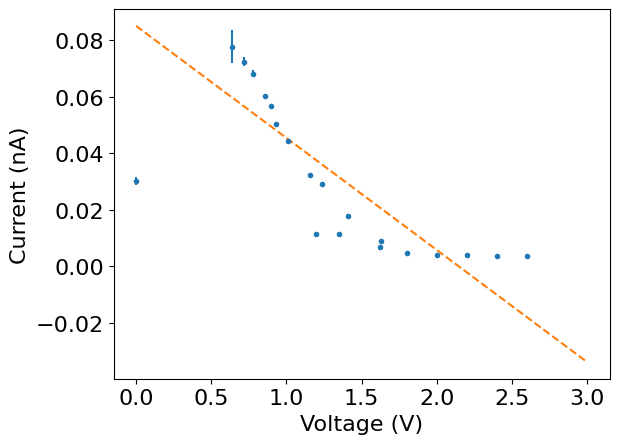

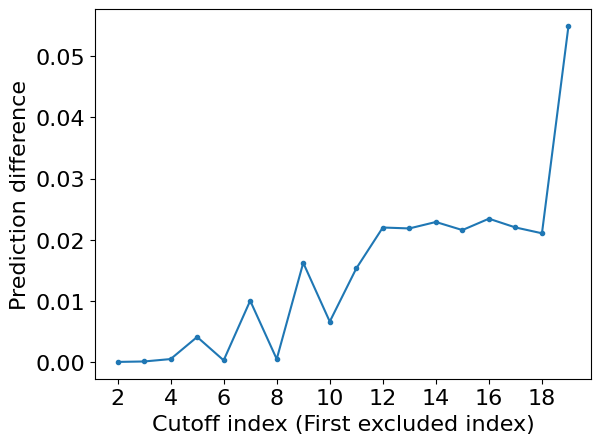

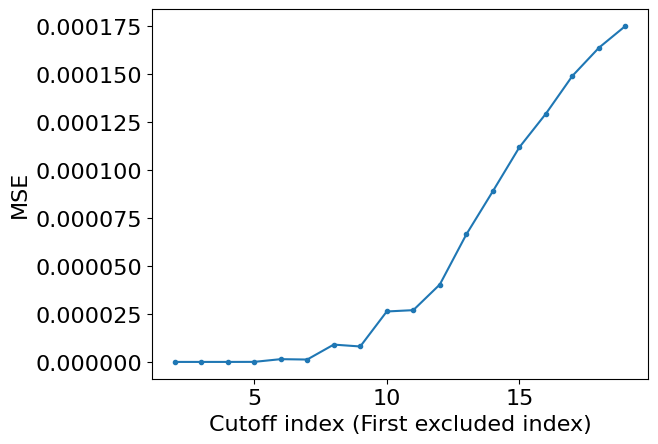

In [1664]:
# 435.8 nm right tail
vc_pairs435 = list(zip([pt[1] for pt in avg_data_by_wl[435.8] if pt[4] == 2],[pt[2] for pt in avg_data_by_wl[435.8] if pt[4] == 2],[pt[3] for pt in avg_data_by_wl[435.8] if pt[4] == 2]))
vc_pairs435.sort(key = lambda x: x[0], reverse=True)
voltages435 = [x[0] for x in vc_pairs435]
currents435 = [x[1] for x in vc_pairs435]
errors435 = [x[2] for x in vc_pairs435]
mses435 = []

norm_shift = zero_voltage_current_546 - max(currents435)
for i in range(len(currents435)):
    currents435[i] = currents435[i] +  norm_shift
print(voltages435)

pts_for_predicted = np.linspace(0, 3, num=30)
differences435 = []

for i in range(2,len(currents435)):
    cutoff = i
    popt, pcov = curve_fit(linear,voltages435[:cutoff],currents435[:cutoff],[0,0.01], absolute_sigma=True)
    differences435.append(abs(currents435[cutoff] - linear(voltages435[cutoff], *popt)))
    predicted_line = linear(pts_for_predicted, *popt)
    mses435.append(calc_mse(linear,voltages435[:cutoff],currents435[:cutoff],popt))

    # print("Cutting off at index", cutoff)
    # print("Optimal parameters", popt)
    # print("Difference with prediction at one past cutoff", abs(currents435[cutoff + 1] - linear(voltages435[cutoff + 1], *popt)))

plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages435,currents435,fmt = '.', yerr=errors435)
plt.plot(pts_for_predicted, predicted_line, linestyle='--')
plt.show()
fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("Prediction difference")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents435)),differences435, marker = '.')
plt.show()

plt.ylabel("MSE")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents435)),mses435, marker='.')
plt.show()


# for i in range(len(differences435)-1):
#     print(i + 1 + 2, "-", i + 2, "=", differences435[i + 1] - differences435[i])

In [1669]:
mse_differences435 = []
for i in range(0,len(mses435)-1):
    mse_differences435.append(mses435[i+1] - mses435[i])
    print("cutoff pt:", i + 2, mses435[i+1] - mses435[i])
print(voltages435[9])

cutoff pt: 2 2.2050000000001048e-10
cutoff pt: 3 1.3525500000000991e-09
cutoff pt: 4 2.211501000000103e-08
cutoff pt: 5 1.4152283175458633e-06
cutoff pt: 6 -1.9578256249797718e-07
cutoff pt: 7 7.792219629013594e-06
cutoff pt: 8 -9.82452856618392e-07
cutoff pt: 9 1.8256740028862628e-05
cutoff pt: 10 6.895253697002548e-07
cutoff pt: 11 1.3375351333770788e-05
cutoff pt: 12 2.6133077924997003e-05
cutoff pt: 13 2.2522635845009524e-05
cutoff pt: 14 2.2929547454099384e-05
cutoff pt: 15 1.7512795640915935e-05
cutoff pt: 16 1.9714447541521252e-05
cutoff pt: 17 1.4689848620233188e-05
cutoff pt: 18 1.1362168852092523e-05
1.24


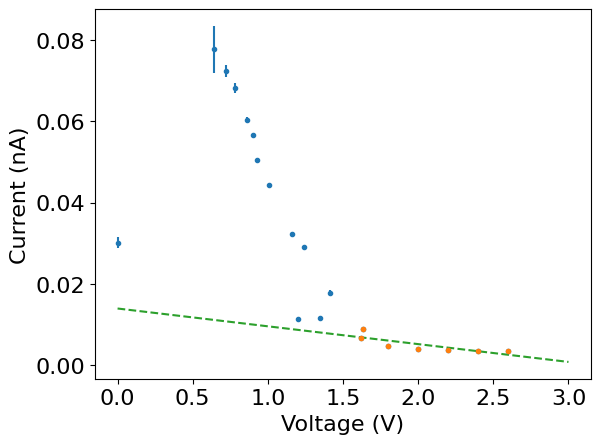

0.01005976333915173
0.0 1.62
[-0.004  0.014]
8.052900587443089e-06


In [1648]:
# for 435, using cutoff 7 for right tail
cutoff_r = 7
popt_r, pcov_r = curve_fit(linear,voltages435[:cutoff_r],currents435[:cutoff_r],[-0.1,0.01], absolute_sigma=True)
predicted_line_r = linear(pts_for_predicted, *popt_r)
    
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages435,currents435,yerr=errors435, fmt = '.')
plt.errorbar(voltages435[:cutoff_r],currents435[:cutoff_r], fmt = '.')

plt.plot(pts_for_predicted, predicted_line_r, linestyle='--')
plt.show()

print(currents435[cutoff_r] - linear(voltages435[cutoff_r], *popt_r))
print(voltages435[cutoff],voltages435[cutoff_r-1])
print(popt_r)
print(mses435[cutoff_r])

[np.float64(0.64), np.float64(0.72), np.float64(0.78), np.float64(0.86), np.float64(0.9), np.float64(0.93), np.float64(1.01), np.float64(1.16), np.float64(1.2), np.float64(1.24), np.float64(1.35), np.float64(1.41), np.float64(1.62), np.float64(1.63), np.float64(1.8), np.float64(2.0), np.float64(2.2), np.float64(2.4), np.float64(2.6)]


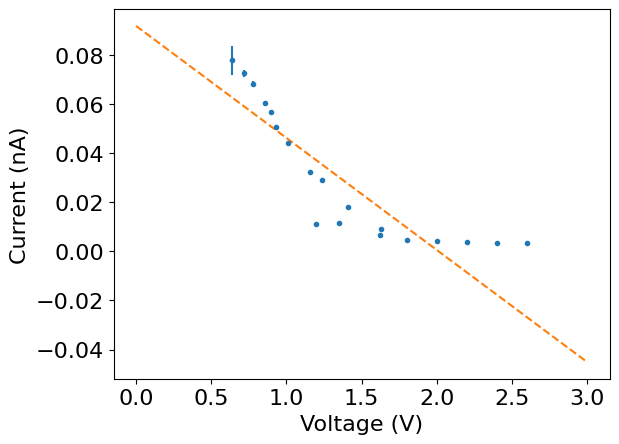

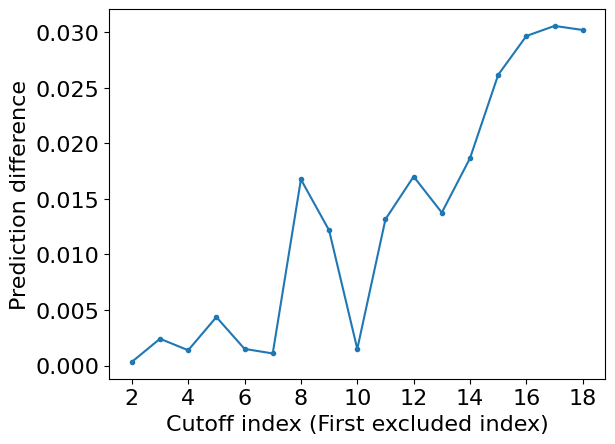

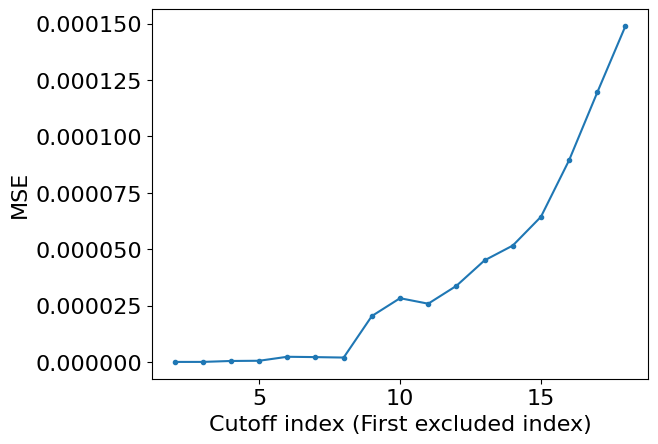

In [1599]:
# 435.8 nm left tail
# removed 0V data point
vc_pairs435 = list(zip([pt[1] for pt in avg_data_by_wl[435.8] if pt[4] == 2],[pt[2] for pt in avg_data_by_wl[435.8] if pt[4] == 2],[pt[3] for pt in avg_data_by_wl[435.8] if pt[4] == 2]))
vc_pairs435.sort(key = lambda x: x[0])
vc_pairs435 = vc_pairs435[1:]
voltages435 = [x[0] for x in vc_pairs435]
currents435 = [x[1] for x in vc_pairs435]
errors435 = [x[2] for x in vc_pairs435]
mses435 = []

norm_shift = zero_voltage_current_546 - max(currents435)
for i in range(len(currents435)):
    currents435[i] = currents435[i] +  norm_shift
print(voltages435)

pts_for_predicted = np.linspace(0, 3, num=30)
differences435 = []

for i in range(2,len(currents435)):
    cutoff = i
    popt, pcov = curve_fit(linear,voltages435[:cutoff],currents435[:cutoff],[0,0.01], absolute_sigma=True)
    differences435.append(abs(currents435[cutoff] - linear(voltages435[cutoff], *popt)))
    predicted_line = linear(pts_for_predicted, *popt)
    mses435.append(calc_mse(linear,voltages435[:cutoff],currents435[:cutoff],popt))

    # print("Cutting off at index", cutoff)
    # print("Optimal parameters", popt)
    # print("Difference with prediction at one past cutoff", abs(currents435[cutoff + 1] - linear(voltages435[cutoff + 1], *popt)))

plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages435,currents435,fmt = '.', yerr=errors435)
plt.plot(pts_for_predicted, predicted_line, linestyle='--')
plt.show()
fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("Prediction difference")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents435)),differences435, marker = '.')
plt.show()

plt.ylabel("MSE")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents435)),mses435, marker='.')
plt.show()


# for i in range(len(differences435)-1):
#     print(i + 1 + 2, "-", i + 2, "=", differences435[i + 1] - differences435[i])

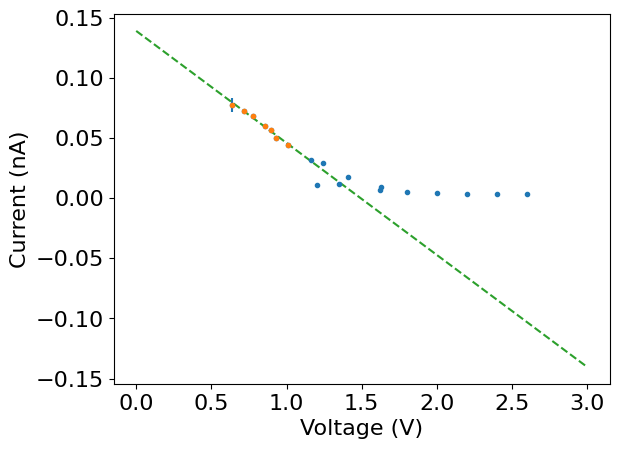

0.001087071110405624
1.16
[-0.093  0.139]


In [1600]:
# for 435, using cutoff 7 for left tail
cutoff_l = 7
popt_l, pcov_l = curve_fit(linear,voltages435[:cutoff_l],currents435[:cutoff_l],[-0.1,0.01], absolute_sigma=True)
predicted_line_l = linear(pts_for_predicted, *popt_l)
    
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages435,currents435,yerr=errors435, fmt = '.')
plt.errorbar(voltages435[:cutoff_l],currents435[:cutoff_l], fmt = '.')

plt.plot(pts_for_predicted, predicted_line_l, linestyle='--')
plt.show()

print(currents435[cutoff_l] - linear(voltages435[cutoff_l], *popt_l))
print(voltages435[cutoff_l])
print(popt_l)


-0.09315548147931571 0.1391502874056006 -0.004380286900899023 0.013949441191115887


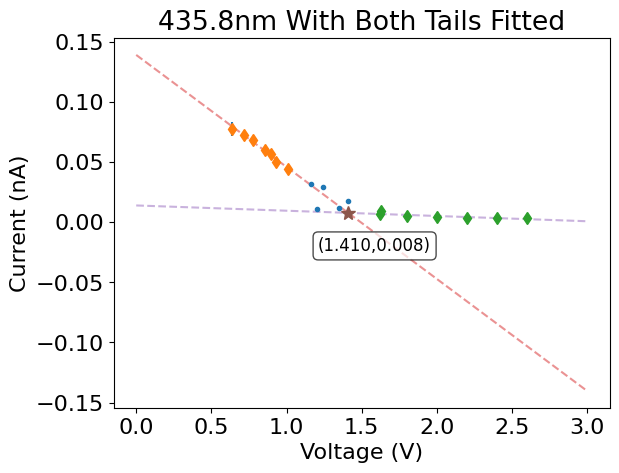

In [1601]:
plt.errorbar(voltages435,currents435,yerr=errors435, fmt = '.')
plt.errorbar(voltages435[:cutoff_l],currents435[:cutoff_l], fmt = 'd')
plt.errorbar(voltages435[len(voltages435) - cutoff_r:],currents435[len(voltages435) - cutoff_r:], fmt = 'd')

plt.plot(pts_for_predicted, predicted_line_l, linestyle='--',alpha =0.5)
plt.plot(pts_for_predicted, predicted_line_r, linestyle='--', alpha = 0.5)

plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
inter_x,inter_y = find_intersect(*popt_l,*popt_r)
plt.plot(inter_x,inter_y,marker = '*',ms = 10)
intersection_text = f"({inter_x:.3f},{inter_y:.3f})"
plt.text(
    inter_x - 0.2 , inter_y-0.02,intersection_text,    
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))
plt.title("435.8nm With Both Tails Fitted")
plt.savefig("435nm_both_tail_fit.pdf",bbox_inches='tight')

# 365 nm Analysis

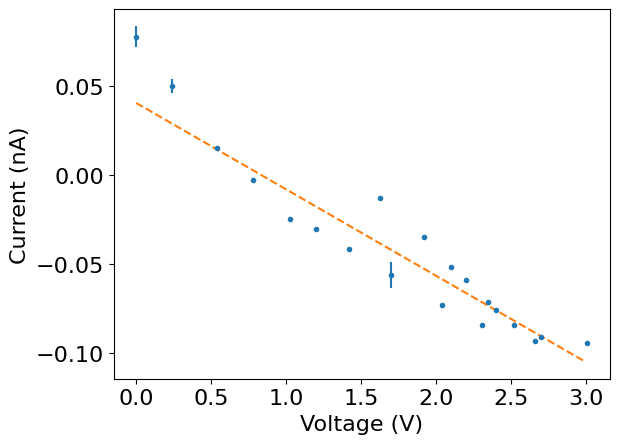

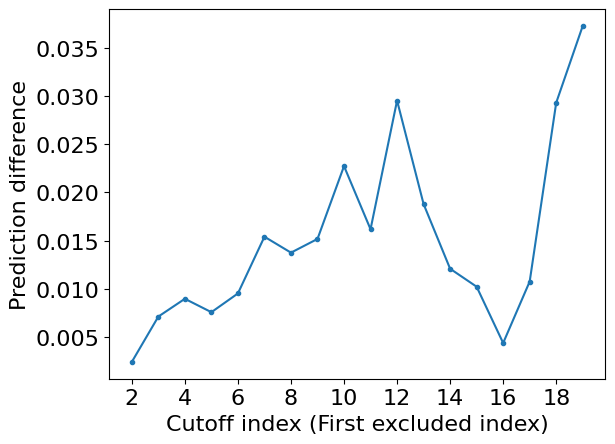

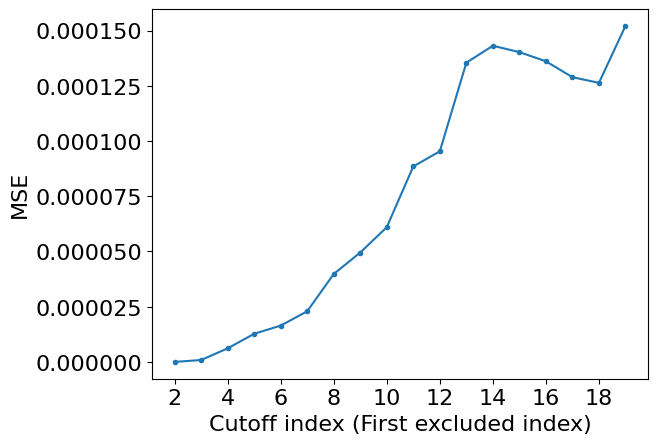

In [1621]:
# 365 nm fitting to right tail
vc_pairs365 = list(zip([pt[1] for pt in avg_data_by_wl[365] if pt[4] == 2],[pt[2] for pt in avg_data_by_wl[365] if pt[4] == 2],[pt[3] for pt in avg_data_by_wl[365] if pt[4] == 2]))
vc_pairs365.sort(key = lambda x: x[0], reverse=True)
voltages365 = [x[0] for x in vc_pairs365]
currents365 = [x[1] for x in vc_pairs365]
errors365 = [x[2] for x in vc_pairs365]
mses365 = []

norm_shift = zero_voltage_current_546 - max(currents365)
for i in range(len(currents365)):
    currents365[i] = currents365[i] +  norm_shift
pts_for_predicted = np.linspace(0, 3, num=30)
differences365 = []

for i in range(2,len(currents365)):
    cutoff = i
    popt, pcov = curve_fit(linear,voltages365[:cutoff],currents365[:cutoff],[0,0.01], absolute_sigma=True)
    differences365.append(abs(currents365[cutoff] - linear(voltages365[cutoff], *popt)))
    predicted_line = linear(pts_for_predicted, *popt)
    mses365.append(calc_mse(linear,voltages365[:cutoff],currents365[:cutoff],popt))

    # print("Cutting off at index", cutoff)
    # print("Optimal parameters", popt)
    # print("Difference with prediction at one past cutoff", abs(currents365[cutoff + 1] - linear(voltages365[cutoff + 1], *popt)))
    # print(calc_chi2(linear,voltages365[:cutoff],currents365[:cutoff],errors365[:cutoff],popt))


plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages365,currents365,fmt = '.', yerr=errors365)
plt.plot(pts_for_predicted, predicted_line, linestyle='--')
plt.show()

fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("Prediction difference")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents365)),differences365, marker = '.')
plt.show()

fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("MSE")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents365)),mses365, marker='.')
plt.show()

# for i in range(len(differences365) - 1):
#     print(i + 1 + 2, "-", i + 2, "=", differences365[i + 1] - differences365[i])

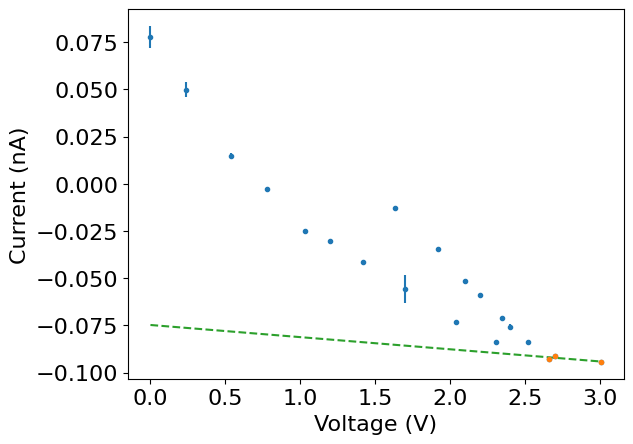

0.007139332108731522
2.52 2.66
[-0.006 -0.075]
1.2724273080272593e-05


In [1603]:
# 365nm, using cutoff 3 for right tail
cutoff_r = 3
popt_r, pcov_r = curve_fit(linear,voltages365[:cutoff_r],currents365[:cutoff_r],[-0.1,0.01], absolute_sigma=True)
predicted_line_r = linear(pts_for_predicted, *popt_r)
    
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages365,currents365,yerr=errors365, fmt = '.')
plt.errorbar(voltages365[:cutoff_r],currents365[:cutoff_r], fmt = '.')

plt.plot(pts_for_predicted, predicted_line_r, linestyle='--')
plt.show()

print(currents365[cutoff_r] - linear(voltages365[cutoff_r], *popt_r))
print(voltages365[cutoff_r], voltages365[cutoff_r-1])
print(popt_r)
print(mses365[cutoff_r])

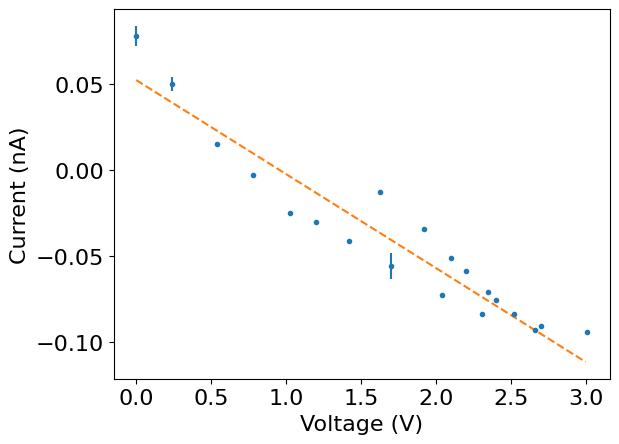

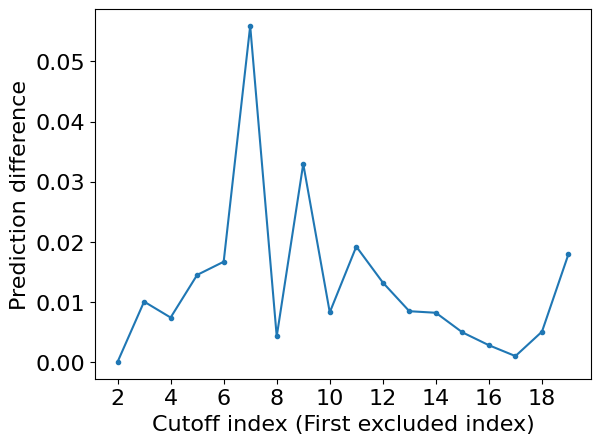

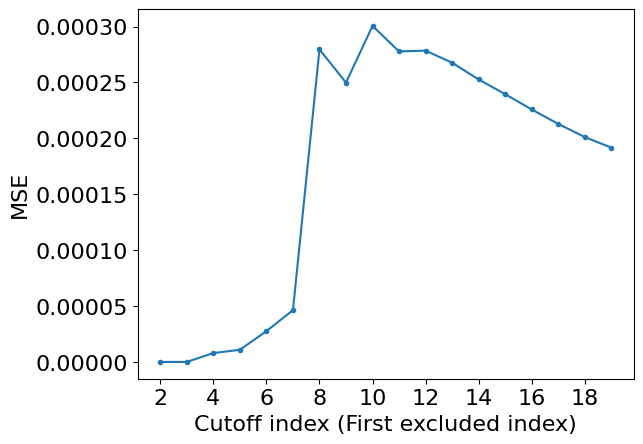

In [1604]:
# 365 nm fitting to left tail
vc_pairs365 = list(zip([pt[1] for pt in avg_data_by_wl[365] if pt[4] == 2],[pt[2] for pt in avg_data_by_wl[365] if pt[4] == 2],[pt[3] for pt in avg_data_by_wl[365] if pt[4] == 2]))
vc_pairs365.sort(key = lambda x: x[0])
voltages365 = [x[0] for x in vc_pairs365]
currents365 = [x[1] for x in vc_pairs365]
errors365 = [x[2] for x in vc_pairs365]
mses365 = []

norm_shift = zero_voltage_current_546 - max(currents365)
for i in range(len(currents365)):
    currents365[i] = currents365[i] +  norm_shift
pts_for_predicted = np.linspace(0, 3, num=30)
differences365 = []

for i in range(2,len(currents365)):
    cutoff = i
    popt, pcov = curve_fit(linear,voltages365[:cutoff],currents365[:cutoff],[0,0.01], absolute_sigma=True)
    differences365.append(abs(currents365[cutoff] - linear(voltages365[cutoff], *popt)))
    predicted_line = linear(pts_for_predicted, *popt)
    mses365.append(calc_mse(linear,voltages365[:cutoff],currents365[:cutoff],popt))

    # print("Cutting off at index", cutoff)
    # print("Optimal parameters", popt)
    # print("Difference with prediction at one past cutoff", abs(currents365[cutoff + 1] - linear(voltages365[cutoff + 1], *popt)))
    # print(calc_chi2(linear,voltages365[:cutoff],currents365[:cutoff],errors365[:cutoff],popt))


plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages365,currents365,fmt = '.', yerr=errors365)
plt.plot(pts_for_predicted, predicted_line, linestyle='--')
plt.show()

fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("Prediction difference")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents365)),differences365, marker = '.')
plt.show()

fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("MSE")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents365)),mses365, marker='.')
plt.show()

# for i in range(len(differences365) - 1):
#     print(i + 1 + 2, "-", i + 2, "=", differences365[i + 1] - differences365[i])

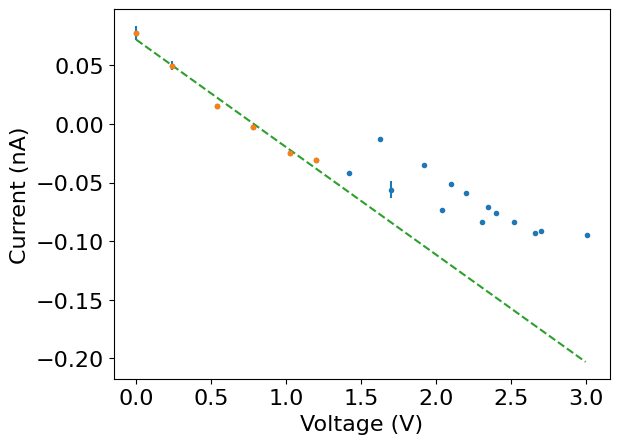

0.016670214732766003
1.42
[-0.092  0.072]


In [1605]:
# 365nm, using cutoff 6 for left tail
cutoff_l = 6
popt_l, pcov_l = curve_fit(linear,voltages365[:cutoff_l],currents365[:cutoff_l],[-0.1,0.01], absolute_sigma=True)
predicted_line_l = linear(pts_for_predicted, *popt_l)
    
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages365,currents365,yerr=errors365, fmt = '.')
plt.errorbar(voltages365[:cutoff_l],currents365[:cutoff_l], fmt = '.')

plt.plot(pts_for_predicted, predicted_line_l, linestyle='--')
plt.show()

print(currents365[cutoff_l] - linear(voltages365[cutoff_l], *popt_l))
print(voltages365[cutoff_l])
print(popt_l)

-0.09164340135234587 0.07194941518756512 -0.006439510726865555 -0.07481476507703036


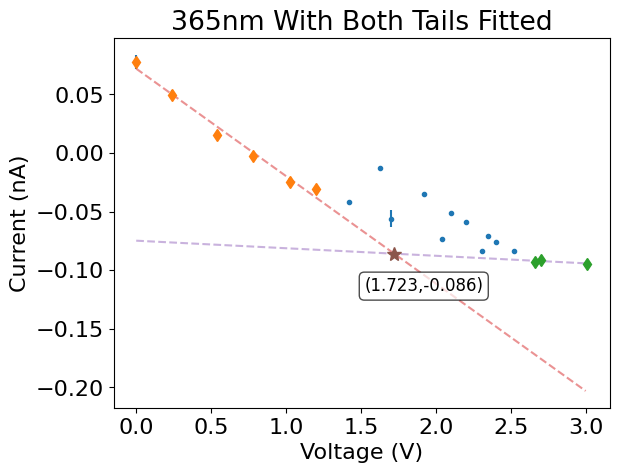

In [1606]:
plt.errorbar(voltages365,currents365,yerr=errors365, fmt = '.')
plt.errorbar(voltages365[:cutoff_l],currents365[:cutoff_l], fmt = 'd')
plt.errorbar(voltages365[len(voltages365) - cutoff_r:],currents365[len(voltages365) - cutoff_r:], fmt = 'd')
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.plot(pts_for_predicted, predicted_line_l, linestyle='--',alpha =0.5)
plt.plot(pts_for_predicted, predicted_line_r, linestyle='--', alpha = 0.5)

plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
inter_x,inter_y = find_intersect(*popt_l,*popt_r)
plt.plot(inter_x,inter_y,marker = '*',ms = 10)
intersection_text = f"({inter_x:.3f},{inter_y:.3f})"
plt.text(
    inter_x - 0.2 , inter_y-0.02,intersection_text,    
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))
plt.title("365nm With Both Tails Fitted")
plt.savefig("365nm_both_tail_fit.pdf",bbox_inches='tight')

# 577 nm Analysis

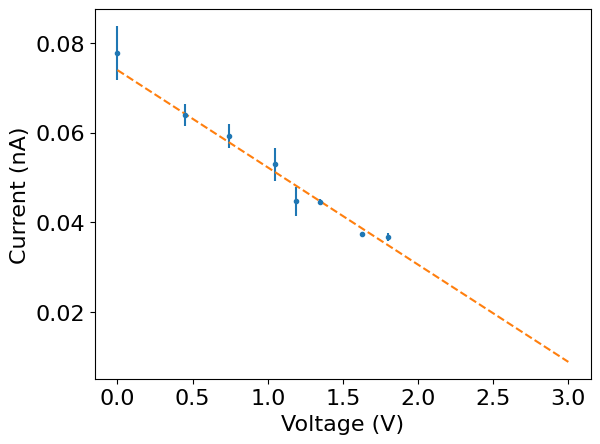

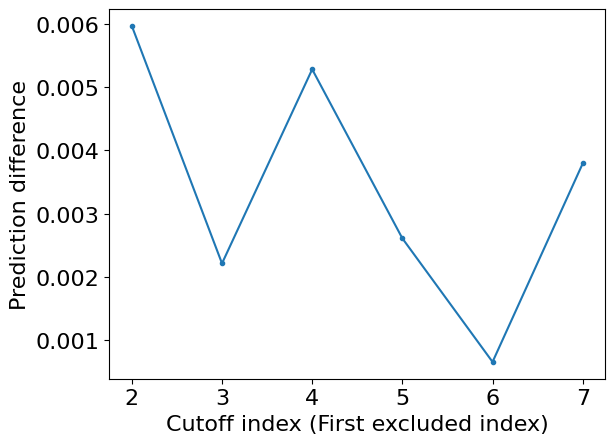

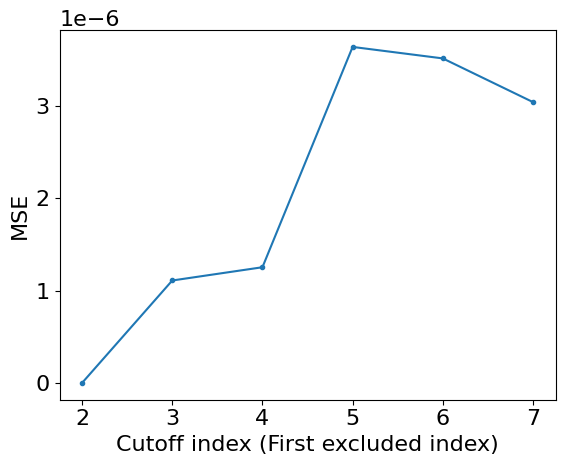

In [1607]:
# 577 nm fitting to right tail
vc_pairs577 = list(zip([pt[1] for pt in avg_data_by_wl[577] if pt[4] == 1],[pt[2] for pt in avg_data_by_wl[577] if pt[4] == 1],[pt[3] for pt in avg_data_by_wl[577] if pt[4] == 1]))
vc_pairs577.sort(key = lambda x: x[0], reverse=True)
voltages577 = [x[0] for x in vc_pairs577]
currents577 = [x[1] for x in vc_pairs577]
errors577 = [x[2] for x in vc_pairs577]
mses577 = []

norm_shift = zero_voltage_current_546 - max(currents577)
for i in range(len(currents577)):
    currents577[i] = currents577[i] +  norm_shift
pts_for_predicted = np.linspace(0, 3, num=30)
differences577 = []

for i in range(2,len(currents577)):
    cutoff = i
    popt, pcov = curve_fit(linear,voltages577[:cutoff],currents577[:cutoff],[0,0.01], absolute_sigma=True)
    differences577.append(abs(currents577[cutoff] - linear(voltages577[cutoff], *popt)))
    predicted_line = linear(pts_for_predicted, *popt)
    mses577.append(calc_mse(linear,voltages577[:cutoff],currents577[:cutoff],popt))

    # print("Cutting off at index", cutoff)
    # print("Optimal parameters", popt)
    # print("Difference with prediction at one past cutoff", abs(currents577[cutoff + 1] - linear(voltages577[cutoff + 1], *popt)))
    # print(calc_chi2(linear,voltages577[:cutoff],currents577[:cutoff],errors577[:cutoff],popt))


plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages577,currents577,fmt = '.', yerr=errors577)
plt.plot(pts_for_predicted, predicted_line, linestyle='--')
plt.show()

fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("Prediction difference")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents577)),differences577, marker = '.')
plt.show()

fig,ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("MSE")
plt.xlabel("Cutoff index (First excluded index)")
plt.plot(range(2,len(currents577)),mses577, marker='.')
plt.show()

# for i in range(len(differences577) - 1):
#     print(i + 1 + 2, "-", i + 2, "=", differences577[i + 1] - differences577[i])

# Planck's Analysis

In [1608]:
# value for 404.7 from interesction is weird i orginally had 1.64356

In [1682]:
cv_data = np.genfromtxt('cutoff_voltages.csv', delimiter=',', skip_header=1, usecols=[0,1,2,3], invalid_raise=False)
print(cv_data)

[[365.      2.66    2.52    1.723]
 [404.7     2.14    2.05    1.132]
 [435.8     1.62    1.41    1.41 ]
 [546.1     1.1     0.9     0.836]
 [577.    -99.    -99.    -99.   ]]


In [1683]:
c = 299792458 # speed of light in m/s
nm_per_m = 10**9
e = 1.60217663*10**(-19) # electron charge in coulombs
freqs = c/((cv_data[0:4:,0])/nm_per_m)
freq_scale = 1e14
colors = ['orange','blue','green']
methods = ['Last Fitted Point','First Unfitted Point','Tangent Line Intersection']
sigma=[0.14,0.09,0.21,0.2]
absolute_sigma=True

In [1695]:
print(c/((365)/nm_per_m))

821349200000000.0


(np.float64(2.535890327336838), np.float64(1.267945163668419), np.float64(0.7185907219108015))
Calculated value of Planck's Constant: 9.697004866895447e-34 J*s with uncertainty: 1.5762102078382415e-34 J*s
Calculated value of Cutoff Voltage: 2.5151766677116436 eV with uncertainty: 9.837930340041483e-16 eV
--------------------------------------------------------------------------------------


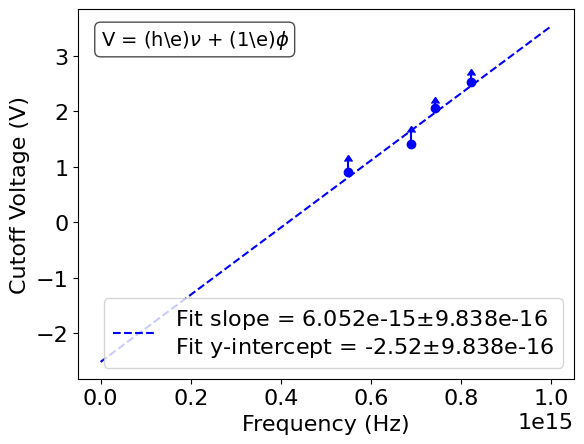

In [1706]:
# Just col 2 of CSV data, which is using the first unfitted point (systematically lower voltage)
for col in [2]:
    popt_scaled, pcov_scaled = curve_fit(linear,freqs,cv_data[0:4:,col])
    m = popt_scaled[0]
    b = popt_scaled[1]
    err_m = (pcov_scaled[0][0])**0.5
    err_b = (pcov_scaled[0][0])**0.5

    # pts_for_predicted = np.linspace(350, 580, num=50)
    pts_for_predicted = np.linspace(-1, 10*freq_scale, num=50)

    predicted_line = linear(pts_for_predicted, m,b)

    plt.errorbar(freqs,cv_data[0:4:,col],color = colors[col - 1], fmt = 'o', yerr = sigma, lolims = True)
    plt.plot(pts_for_predicted, predicted_line, linestyle='--',color = colors[col - 1],
             label="Fit slope = " + f"{m:0.3e}" + "$\\pm$" + f"{err_m:0.3e}" +"\nFit y-intercept = " + f"{b:0.3}" + "$\\pm$" + f"{err_b:0.3e}")
    # plt.scatter([c/((365)/nm_per_m)],[2.66], color = 'green',marker = '*')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Cutoff Voltage (V)")
    print(calc_chi2(linear,freqs,cv_data[0:4:,col],[0.14,0.09,0.21,0.2],[m,b]))
    print(f"Calculated value of Planck's Constant: {m*e} J*s with uncertainty: {(err_m)*e} J*s")
    print(f"Calculated value of Cutoff Voltage: {-b} eV with uncertainty: {(err_b)} eV")
    print("--------------------------------------------------------------------------------------")
# plt.xlim(0.4*freq_scale,10*freq_scale)
# plt.ylim(0.2,3.5)
plt.text(
    0.7, 3.5,
    "V = (h\\e)$\\nu$ + (1\\e)$\\phi$",    
    ha='left', va='top',
    fontsize=14,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))
plt.legend()
plt.savefig("single_fit.pdf",bbox_inches = 'tight')

(np.float64(1.4299843187176948), np.float64(0.7149921593588474), np.float64(0.5108040526088284))
Calculated value of Planck's Constant: 9.211317355872654e-34 J*s with uncertainty: 1.296361401333284e-34 J*s
Calculated value of Cutoff Voltage: 2.1430521568222076 eV with uncertainty: 5050.161960234692 eV
--------------------------------------------------------------------------------------
(np.float64(2.535890327336838), np.float64(1.267945163668419), np.float64(0.7185907219108015))
Calculated value of Planck's Constant: 9.697004866895447e-34 J*s with uncertainty: 1.5762102078382415e-34 J*s
Calculated value of Cutoff Voltage: 2.5151766677116436 eV with uncertainty: 6140.353164458205 eV
--------------------------------------------------------------------------------------


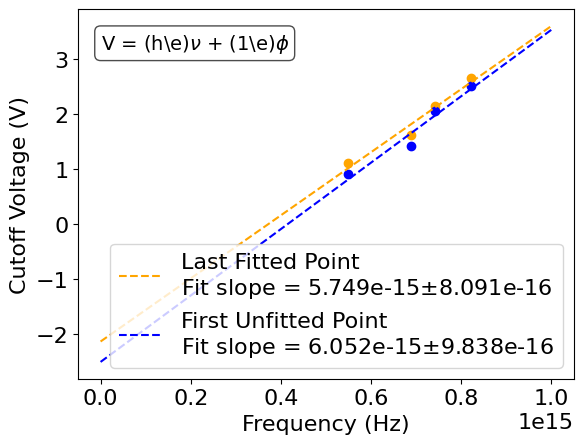

In [ ]:
for col in [1,2]:
    popt_scaled, pcov_scaled = curve_fit(linear,freqs,cv_data[0:4:,col])
    m = popt_scaled[0]
    b = popt_scaled[1]
    err_m = (pcov_scaled[0][0])**0.5
    err_b = (pcov_scaled[0][0])**0.5

    # pts_for_predicted = np.linspace(350, 580, num=50)
    pts_for_predicted = np.linspace(-1, 10*freq_scale, num=50)

    predicted_line = linear(pts_for_predicted, m,b)

    plt.scatter(freqs,cv_data[0:4:,col],color = colors[col - 1])
    plt.plot(pts_for_predicted, predicted_line, linestyle='--',color = colors[col - 1],
             label=methods[col-1] + "\nFit slope = " + f"{m:0.3e}" + "$\\pm$" + f"{err_m:0.3e}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Cutoff Voltage (V)")
    print(calc_chi2(linear,freqs,cv_data[0:4:,col],[0.14,0.09,0.21,0.2],[m,b]))
    print(f"Calculated value of Planck's Constant: {m*e} J*s with uncertainty: {(err_m)*e} J*s")
    print(f"Calculated value of Cutoff Voltage: {-b} eV with uncertainty: {(err_b)} eV")
    print("--------------------------------------------------------------------------------------")
# plt.xlim(0.4*freq_scale,10*freq_scale)
# plt.ylim(0.2,3.5)
plt.text(
    0.7, 3.5,
    "V = (h\\e)$\\nu$ + (1\\e)$\\phi$",    
    ha='left', va='top',
    fontsize=14,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))
plt.legend()
plt.savefig("methods_fit_lines.pdf",bbox_inches = 'tight')

In [1612]:
# Central wavelength
# Calculated value of Planck's Constant: 9.697004866895447e-34 J*s with uncertainty: 1.5762102078382415e-34 J*s
# Calculated value of Cutoff Voltage: 2.5151766677116436 eV with uncertainty: 9.837930340041483e-16 eV
# --------------------------------------------------------------------------------------
# Calculated value of Planck's Constant: 9.211317355872654e-34 J*s with uncertainty: 1.296361401333284e-34 J*s
# Calculated value of Cutoff Voltage: 2.1430521568222076 eV with uncertainty: 8.0912514704030115e-16 eV
# --------------------------------------------------------------------------------------
# Calculated value of Planck's Constant: 4.6113587248298865e-34 J*s with uncertainty: 1.8617296151177037e-34 J*s
# Calculated value of Cutoff Voltage: 0.7386076886215212 eV with uncertainty: 1.1620002315960032e-15 eV

In [1613]:
# + 2nm 
# Calculated value of Planck's Constant: 9.784298652073721e-34 J*s with uncertainty: 1.5931918730422458e-34 J*s
# Calculated value of Cutoff Voltage: 2.5330509162129924 eV with uncertainty: 9.943921557776348e-16 eV
# --------------------------------------------------------------------------------------
# Calculated value of Planck's Constant: 9.294187917828491e-34 J*s with uncertainty: 1.3112365376191398e-34 J*s
# Calculated value of Cutoff Voltage: 2.1600089821347113 eV with uncertainty: 8.184094768746813e-16 eV
# --------------------------------------------------------------------------------------
# Calculated value of Planck's Constant: 4.653034969370051e-34 J*s with uncertainty: 1.8789597677754103e-34 J*s
# Calculated value of Cutoff Voltage: 0.7471790455980107 eV with uncertainty: 1.1727544470395941e-15 eV
# --------------------------------------------------------------------------------------

In [1614]:
# - 2nm
# Calculated value of Planck's Constant: 9.610080747882837e-34 J*s with uncertainty: 1.5593195970041321e-34 J*s
# Calculated value of Cutoff Voltage: 2.4972970340291023 eV with uncertainty: 9.732507438984004e-16 eV
# --------------------------------------------------------------------------------------
# Calculated value of Planck's Constant: 9.128797668699005e-34 J*s with uncertainty: 1.2815677541667602e-34 J*s
# Calculated value of Cutoff Voltage: 2.126090306910754 eV with uncertainty: 7.998916787138259e-16 eV
# --------------------------------------------------------------------------------------
# Calculated value of Planck's Constant: 4.569860731845036e-34 J*s with uncertainty: 1.8445760694905432e-34 J*s
# Calculated value of Cutoff Voltage: 0.7300341667576452 eV with uncertainty: 1.1512938305001636e-15 eV
# --------------------------------------------------------------------------------------

0.006953311419526672
0.9 1.1
[-0.004  0.   ]
2.1752965903179294e-06 4.440774680917975e-06 1.1596572087527813e-05
0.011913291653649363
2.05 2.14
[-0.005 -0.088]
1.3472192448143483e-05 2.0900921325649073e-05 2.1503820929660097e-05
0.01005976333915173
0.0 1.62
[-0.004  0.014]
8.052900587443089e-06


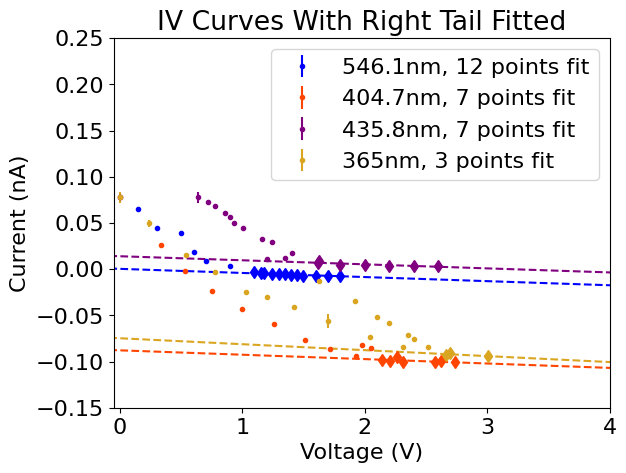

0.007139332108731522
2.52 2.66
[-0.006 -0.075]
1.2724273080272593e-05


In [1677]:
pts_for_predicted = np.linspace(-5, 10, num=30)

# for 546, using cutoff 12 on the right tail (ie use the rightmost point and cutoff 12 wrt to that)
cutoff_r = 12
popt_r, pcov_r = curve_fit(linear,voltages546[:cutoff_r],currents546[:cutoff_r],[-5,7], sigma=errors546[:cutoff_r],absolute_sigma=True)
predicted_line_r = linear(pts_for_predicted, *popt_r)
    
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages546,currents546,yerr=errors546, fmt = '.', color = 'blue', label = f'546.1nm, {cutoff_r} points fit')
plt.errorbar(voltages546[:cutoff_r],currents546[:cutoff_r], fmt = 'd', color = 'blue')
plt.plot(pts_for_predicted, predicted_line_r, linestyle='--', color = 'blue')
plt.title("IV Curves With Right Tail Fitted")

# text_display_string_info = f"""Functional form: $I = m*V + b$
# Best-fit values: m = {popt_r[0]:.5f} $\\pm$ {pcov_r[0][0]**0.5:.5f},
# b = {popt_r[1]:.5f} $\\pm$ {pcov_r[1][1]**0.5:.5f},
# Number of points fit: {cutoff_r}"""
# plt.text(
#     0.51, 0.079,text_display_string_info,    
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))

print(currents546[cutoff_r] - linear(voltages546[cutoff_r], *popt_r))
print(voltages546[cutoff_r], voltages546[cutoff_r-1])
print(popt_r)
print(mses546[cutoff_r-1],mses546[cutoff_r], mses546[cutoff_r+1])

# 404.7 nm, using cutoff 7 for right tail based on rise in MSE past that
cutoff_r = 7
popt_r, pcov_r = curve_fit(linear,voltages404[:cutoff_r],currents404[:cutoff_r],[-0.1,0.01])
predicted_line_r = linear(pts_for_predicted, *popt_r)
    
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages404,currents404,yerr=errors404, fmt = '.', color = 'orangered', label = f'404.7nm, {cutoff_r} points fit')
plt.errorbar(voltages404[:cutoff_r],currents404[:cutoff_r], fmt = 'd', color = 'orangered')

plt.plot(pts_for_predicted, predicted_line_r, linestyle='--', color = 'orangered')

print(currents404[cutoff_r] - linear(voltages404[cutoff_r], *popt_r))
print(voltages404[cutoff_r], voltages404[cutoff_r-1])
print(popt_r)
print(mses404[cutoff_r-1],mses404[cutoff_r],mses404[cutoff_r+1])

# for 435, using cutoff 7 for right tail
cutoff_r = 7
popt_r, pcov_r = curve_fit(linear,voltages435[:cutoff_r],currents435[:cutoff_r],[-0.1,0.01], absolute_sigma=True)
predicted_line_r = linear(pts_for_predicted, *popt_r)
    
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages435[:-1],currents435[:-1],yerr=errors435[:-1], fmt = '.', color = 'purple', label = f'435.8nm, {cutoff_r} points fit')
plt.errorbar(voltages435[:cutoff_r],currents435[:cutoff_r], fmt = 'd', color = 'purple')

plt.plot(pts_for_predicted, predicted_line_r, linestyle='--', color = 'purple')

print(currents435[cutoff_r] - linear(voltages435[cutoff_r], *popt_r))
print(voltages435[cutoff],voltages435[cutoff_r-1])
print(popt_r)
print(mses435[cutoff_r])

# 365nm, using cutoff 3 for right tail
cutoff_r = 3
popt_r, pcov_r = curve_fit(linear,voltages365[:cutoff_r],currents365[:cutoff_r],[-0.1,0.01], absolute_sigma=True)
predicted_line_r = linear(pts_for_predicted, *popt_r)
    
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.errorbar(voltages365,currents365,yerr=errors365, fmt = '.', color = 'goldenrod', label = f'365nm, {cutoff_r} points fit')
plt.errorbar(voltages365[:cutoff_r],currents365[:cutoff_r], fmt = 'd', color = 'goldenrod')

plt.plot(pts_for_predicted, predicted_line_r, linestyle='--', color = 'goldenrod')
plt.ylim(-0.15,0.25)
plt.xlim(-0.05,4)
plt.legend()
plt.savefig("all_iv_fits.pdf",bbox_inches = 'tight')
plt.show()

print(currents365[cutoff_r] - linear(voltages365[cutoff_r], *popt_r))
print(voltages365[cutoff_r], voltages365[cutoff_r-1])
print(popt_r)
print(mses365[cutoff_r])

In [1626]:
print(voltages435)

[np.float64(2.6), np.float64(2.4), np.float64(2.2), np.float64(2.0), np.float64(1.8), np.float64(1.63), np.float64(1.62), np.float64(1.41), np.float64(1.35), np.float64(1.24), np.float64(1.2), np.float64(1.16), np.float64(1.01), np.float64(0.93), np.float64(0.9), np.float64(0.86), np.float64(0.78), np.float64(0.72), np.float64(0.64), np.float64(0.0)]
